# 0. Imports

In [19]:
import os
import datetime
import pandas as pd
import numpy as np
import inflection
import seaborn as sns
import xgboost as xgb
import pickle
import requests
import json

import matplotlib.pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML
from matplotlib import gridspec
from scipy import stats
from tabulate import tabulate
from boruta import BorutaPy

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error

## 0.1 Helper Functions

In [20]:
def mean_percentage_error( y, yhat ):
    return np.mean( ( (y - yhat)/y ) )


def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( (y - yhat)/y ) )


def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat)
    mape = mean_absolute_percentage_error( y, yhat)
    rmse = np.sqrt( mean_squared_error( y, yhat) )
    
    return pd.DataFrame({ 'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse }, index=[0])
    
    
def cross_validation( x_training, kfold, model_name, model, verbose=False):

    m_result_kfold = pd.DataFrame()
    df_kfold = pd.DataFrame()
    cols = ['MAE', 'MAPE', 'RMSE']

    for k in reversed( range( 1, kfold+1 ) ):
        
        if verbose:
            print( '\nKFold Number: {}'.format(k) )

        # start and end date for validation

        # cálculo da data onde se inicia as últimas seis semanas 
        # essa data representa o início do conjunto de dados de validação
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7 )

        # cálculo da data onde termina as últimas seis semanas
        # essa data representa o término do conjunto de dados de validação
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7 )

        # filtering dataset
        training = x_training[ x_training['date'] < validation_start_date ]
        validation = x_training[ (x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date) ]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = model.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1(yvalidation), np.expm1(yhat) )
        
        # store performance of each kfold iteration
        m_result['iteration'] = k
        
        m_result_kfold = pd.concat( [m_result_kfold, m_result], axis=0 )
        
        
    df_kfold[model_name] =  round( np.mean( m_result_kfold[cols] ), 2 ).astype(str) + ' +/- ' + \
                            round( np.std( m_result_kfold[cols] ), 2 ).astype(str)
    df_kfold = df_kfold.T
    
    return m_result_kfold, df_kfold


def cramer_v( x , y):
    
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max( 0, chi2 - (k-1) * (r-1) / (n-1) )
    kcorr = k - np.power( (k-1), 2 ) / (n-1)
    rcorr = r - np.power( (r-1), 2 ) / (n-1)
    
    
    return np.sqrt( ( chi2corr/n ) / ( min( kcorr-1, rcorr-1 ) ) )


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [59]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [22]:
df_sales_raw = pd.read_csv( '../data/train.csv', low_memory=False)
df_store_raw = pd.read_csv( '../data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [23]:
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1. Data Description

## 1.1 Rename Columns

In [24]:
df1 = df_raw.copy()

In [25]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
col_news = list( map( snakecase, cols_old ) )

# rename
df1.columns = col_news

In [26]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
131718,149,6,2015-04-04,5592,461,1,0,0,0,d,a,2610.0,7.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


## 1.2 Data Dimensions

In [27]:
print( 'Number of rows: {}'.format( df1.shape[0] ) )
print( 'Number of columns: {}'.format( df1.shape[1] ) )

Number of rows: 1017209
Number of columns: 18


## 1.3 Data Types

In [28]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [32]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [33]:
df1.isna().sum().sort_values( ascending=False )

promo2_since_year               508031
promo2_since_week               508031
competition_open_since_year     323348
competition_open_since_month    323348
competition_distance              2642
store                                0
day_of_week                          0
promo2                               0
assortment                           0
store_type                           0
school_holiday                       0
state_holiday                        0
promo                                0
open                                 0
customers                            0
sales                                0
date                                 0
promo_interval                       0
dtype: int64

## 1.5 Fillout NA

In [34]:
# promo_interval   
# nulos: loja não possui uma promoção periódica
# criação de uma nova coluna que diz se naquela data estava começando uma nova promoção periódica na loja 
month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['promo_interval'].fillna(0, inplace=True)     
df1['month_map'] = df1['date'].dt.month.map( month_map )
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval']==0 else 
                                                                        1 if x['month_map'] in x['promo_interval'].split(',') else 
                                                                        0, axis=1)

# promo2_since_year  
# nulos: loja não possui uma promoção periódica
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if pd.isna( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1)         
         
# promo2_since_week    
# nulos: loja não possui uma promoção periódica
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if pd.isna( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1)
        
# competition_open_since_year
# nulos: a loja não possui um competidor mais próxima ou a loja possui um competidor próximo, mas não se sabe quando essa loja abriu
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if pd.isna( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1)

# competition_open_since_month
# nulos: a loja não possui um competidor mais próxima ou a loja possui um competidor próximo, mas não se sabe quando essa loja abriu
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if pd.isna( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1)

# competition_distance  
# nulos: não existe nenhum competidor ou o competidor mais próximo está muito distante. 
# Por esse motivo vamos substituir os nulos por uma distância muito alta
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if pd.isna(x) else x )


In [36]:
df1.isna().sum().sort_values( ascending=False )

store                           0
day_of_week                     0
month_map                       0
promo_interval                  0
promo2_since_year               0
promo2_since_week               0
promo2                          0
competition_open_since_year     0
competition_open_since_month    0
competition_distance            0
assortment                      0
store_type                      0
school_holiday                  0
state_holiday                   0
promo                           0
open                            0
customers                       0
sales                           0
date                            0
is_promo                        0
dtype: int64

## 1.6 Change types

In [37]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [38]:
cols = ['competition_open_since_month', 'competition_open_since_year', 'promo2_since_week', 'promo2_since_year']

for col in cols:
    df1[col] = df1[col].astype('int64')
    
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistics

Estatísta de Primeira Ordem

Métricas de tendência central: resumem os dados em um único número
- média, mediana

Métricas de dispersão: mede o quão esparso os dados estão em torno da média/mediana
- viância, desvio padrão, range, min, max, skew (deformação da distribuição em relação a normal) e kurtosis (fala sobre a concentração dos dados)


In [52]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1 Numerical attributes

In [53]:
# tendencia central - media, mediana
t1 = pd.DataFrame( num_attributes.mean() ).T
t2 = pd.DataFrame( num_attributes.median() ).T

# dispersion - std, min, max, range, skew, kurtosis
#skew - assimetria da distribuição dos dados em relação a uma normal
#kurtosis - cauda longa da distribuição
d1 = pd.DataFrame( num_attributes.std() ).T
d2 = pd.DataFrame( num_attributes.min() ).T    
d3 = pd.DataFrame( num_attributes.max() ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.skew() ).T
d6 = pd.DataFrame( num_attributes.kurtosis() ).T

# concat
m1 = pd.concat( [d2, d3, d4, t1, t2, d1, d5, d6] ).T.reset_index()
m1.columns = ['attributes', 'min', 'max', 'range', 'media', 'mediana', 'std', 'skew', 'kurtosis']
m1

,attributes,min,max,range,media,mediana,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908651,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997391,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.926175,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411734,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485759,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.652996,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311087,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515593,-7.235657,124.071304


C:\Users\lalaz\Anaconda3\envs\dsproducao\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

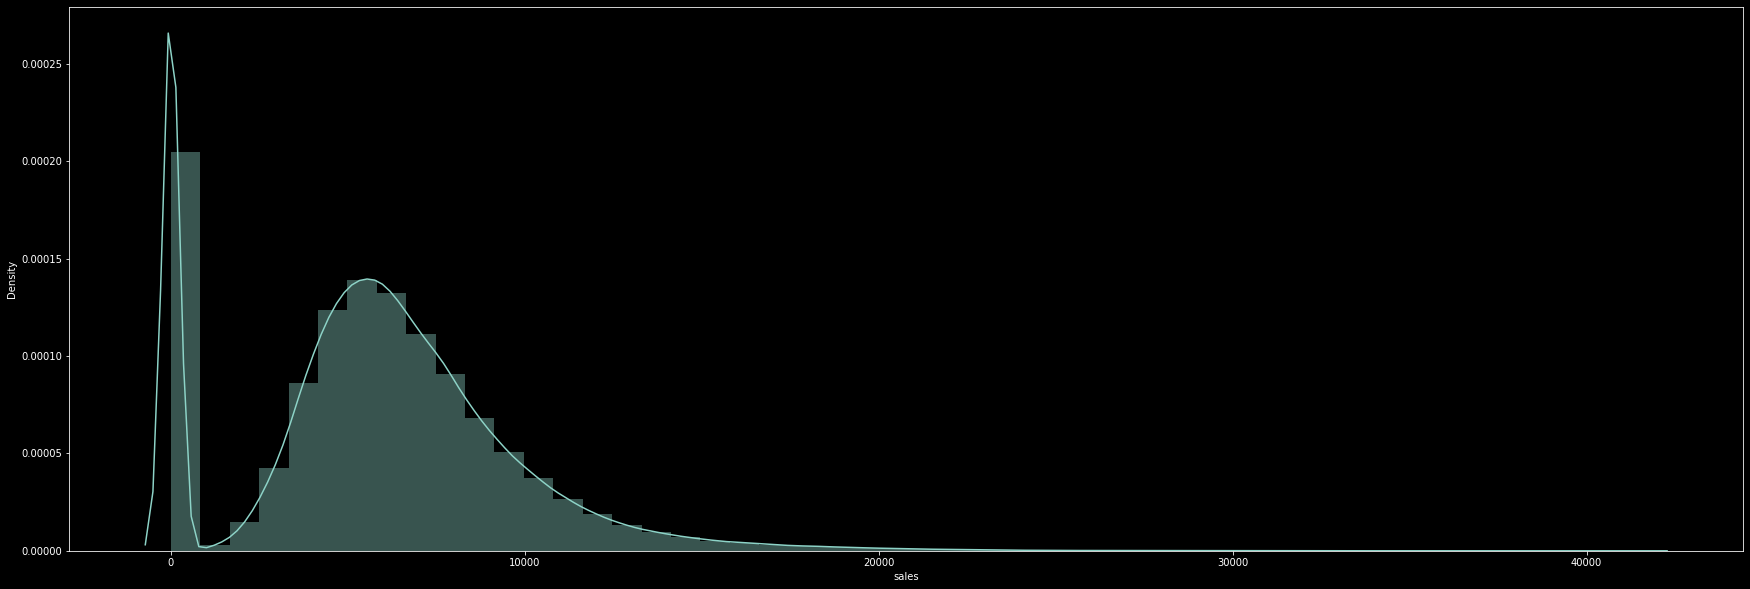

In [54]:
sns.distplot(df1['sales'])

C:\Users\lalaz\Anaconda3\envs\dsproducao\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance'>

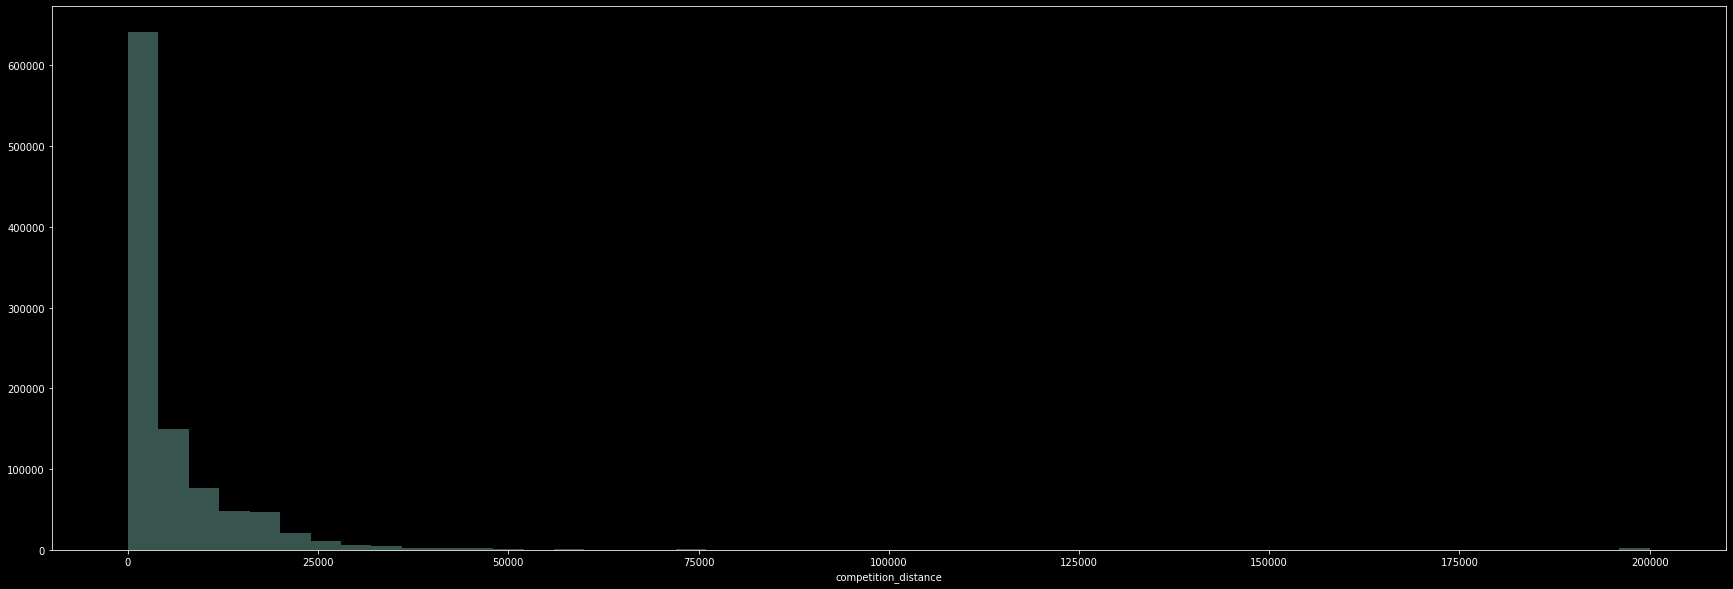

In [55]:
sns.distplot( df1['competition_distance'], kde=False )

### 1.7.2 Categorical Attributes

In [56]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

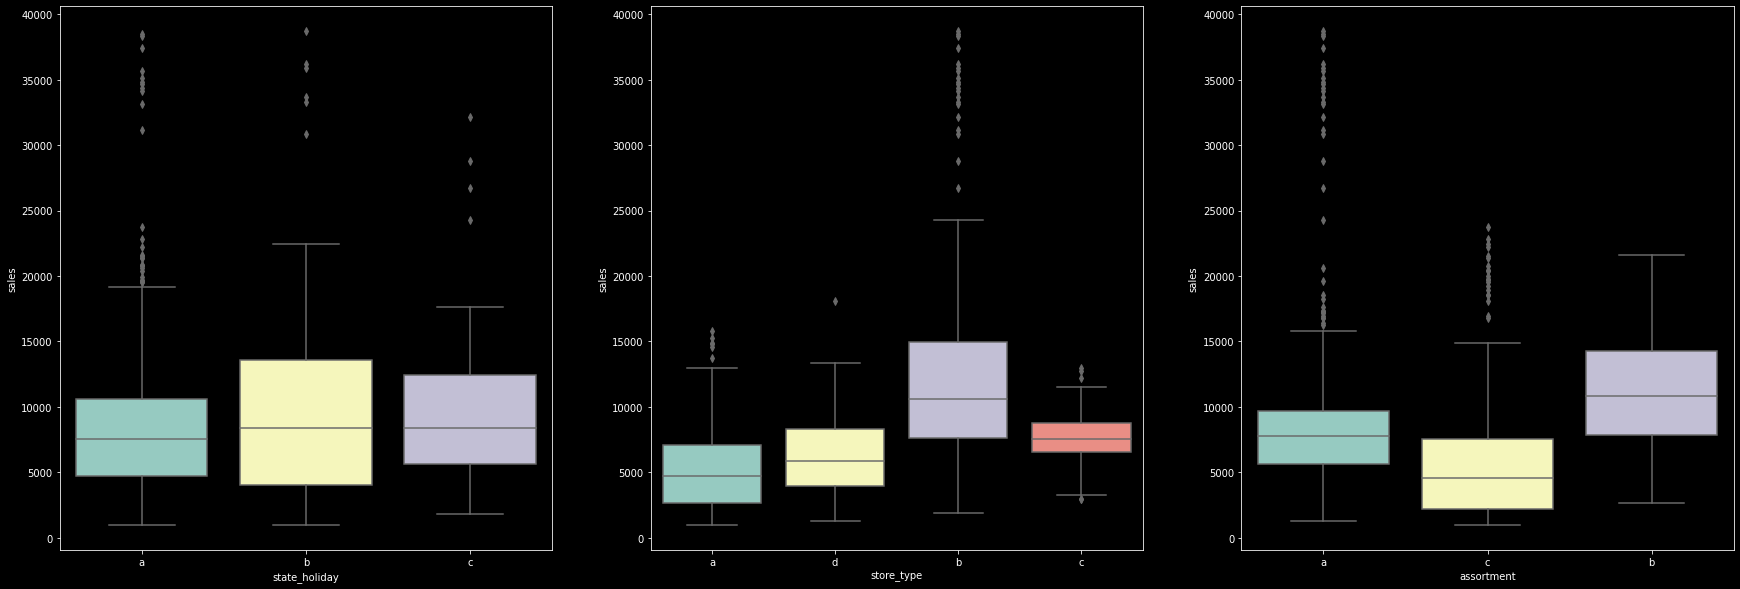

In [57]:
aux = df1[ (df1['state_holiday']!='0') & df1['open']==1 ]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux)

**Interpretação do boxplot**

Ordena-se os dados da variável numérica em ordem crescente:
- Q1: valor máximo onde encontram-se 25% dos dados
- Q2: valor máximo onde encontram-se 50% dos dados
- Q3: valor máximo onde encontram-se 75% dos dados
- min = Q1 - 1.5 * (Q3-Q1)
- max = Q3 + 1.5 * (Q3-Q1)

# 2. Feature Engineering

## 2.1 Mapa mental de hipóteses

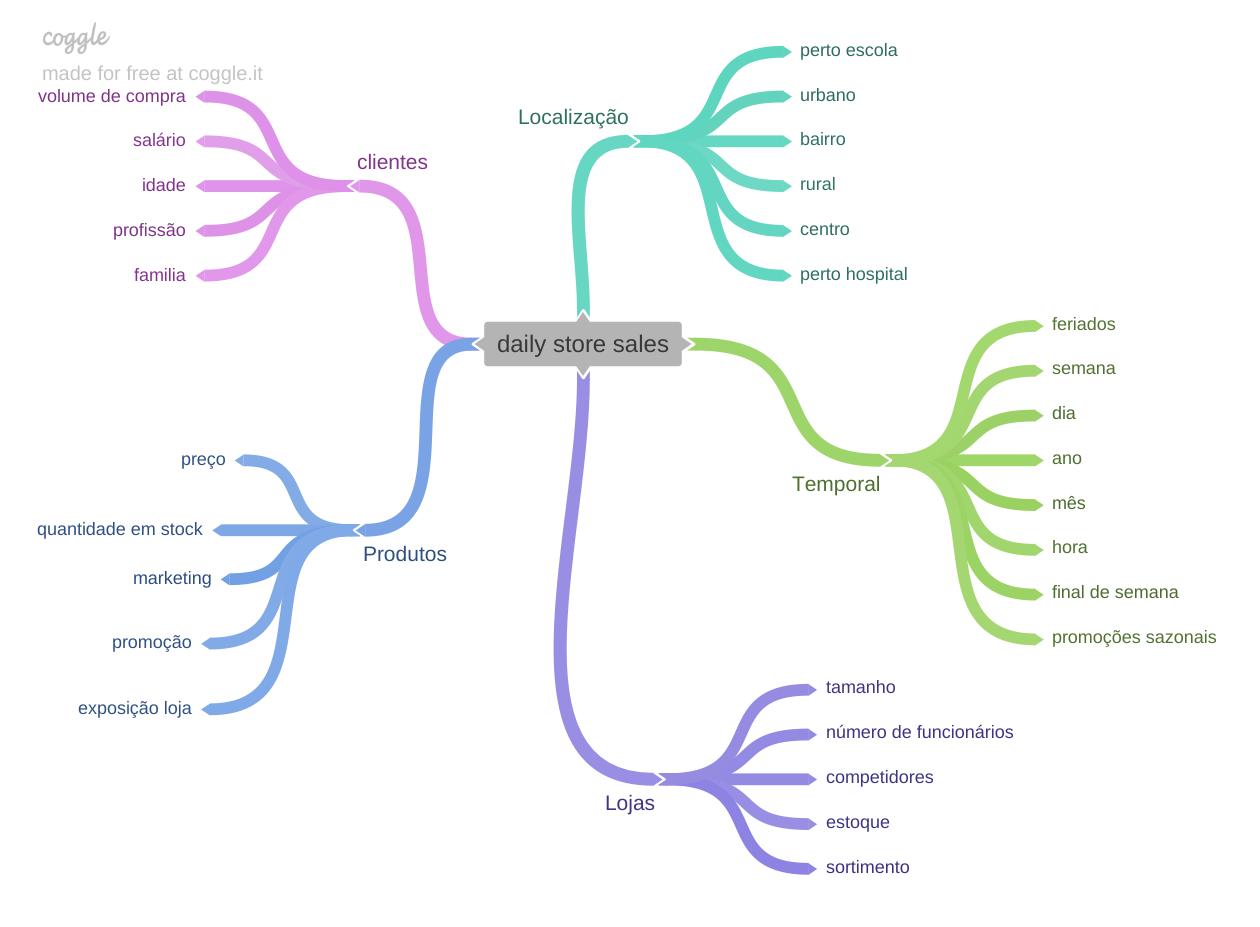

In [40]:
Image('../img/mind-map-hypothesis.png')

## 2.2 Criação das hipóteses

### 2.2.1 Hipóteses da loja

1. Lojas com número maior de funcionários deveriam vender mais.
2. Lojas com maior capacidade de estoque deveriam vender mais.
3. Lojas com maior porte deveriam vender mais.
4. Lojas com maior sortimentos deveriam vender mais.
5. Lojas com competidores mais próximos deveriam vender menos.
6. Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2 Hipóteses do produto

1. Lojas que investem mais em Marketing deveriam vender mais.
2. Lojas com maior exposição de produto deveriam vender mais.
3. Lojas com produtos com preço menor deveriam vender mais.
5. Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.
6. Lojas com promoções ativas por mais tempo deveriam vender mais.
7. Lojas com mais dias de promoção deveriam vender mais.
8. Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 Hipóteses do tempo

1. Lojas abertas durante o feriado de Natal deveriam vender mais.
2. Lojas deveriam vender mais ao longo dos anos.
3. Lojas deveriam vender mais no segundo semestre do ano.
4. Lojas deveriam vender mais depois do dia 10 de cada mês.
5. Lojas deveriam vender menos aos finais de semana.
6. Lojas deveriam vender menos durante os feriados escolares.

### 2.2.4 Hipóteses priorizadas

1. Lojas com maior sortimentos deveriam vender mais
2. Lojas com competidores mais próximos deveriam vender menos
3. Lojas com competidores à mais tempo deveriam vendem mais
4. Lojas com promoções ativas por mais tempo deveriam vender mais
5. Lojas com mais dias de promoção deveriam vender mais
7. Lojas com mais promoções consecutivas deveriam vender mais
8. Lojas abertas durante o feriado de Natal deveriam vender mais
9. Lojas deveriam vender mais ao longo dos anos
10. Lojas deveriam vender mais no segundo semestre do ano
11. Lojas deveriam vender mais depois do dia 10 de cada mês
12. Lojas deveriam vender menos aos finais de semana
13. Lojas deveriam vender menos durante os feriados escolares



## 2.3 Feature Engineering

In [41]:
df2 = df1.copy()

# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype('int64')

# year week
df2['year_week'] = df2['year'].astype('str') + '-' + df2['week_of_year'].astype('str')

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )



In [42]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3. Feature Filtering and Selection

In [43]:
df3 = df2.copy()

In [44]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-31,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-31,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-31,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-31,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-31,2015-04-01,4,2015-07-27,0


## 3.1 Filtragem das linhas

In [45]:
df3 = df3[( df3['open'] != 0) & ( df3['sales'] > 0 )]

## 3.2 Seleção das colunas

In [46]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

In [47]:
df3.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,...,0,2015,7,31,31,2015-31,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,...,1,2015,7,31,31,2015-31,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,...,1,2015,7,31,31,2015-31,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,...,0,2015,7,31,31,2015-31,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,...,0,2015,7,31,31,2015-31,2015-04-01,4,2015-07-27,0


# 4. Exploratory Data Analysis (EDA)

In [49]:
df4 = df3.copy()

## 4.1 Análise univariada

### 4.1.1 Variável resposta

C:\Users\lalaz\Anaconda3\envs\dsproducao\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales'>

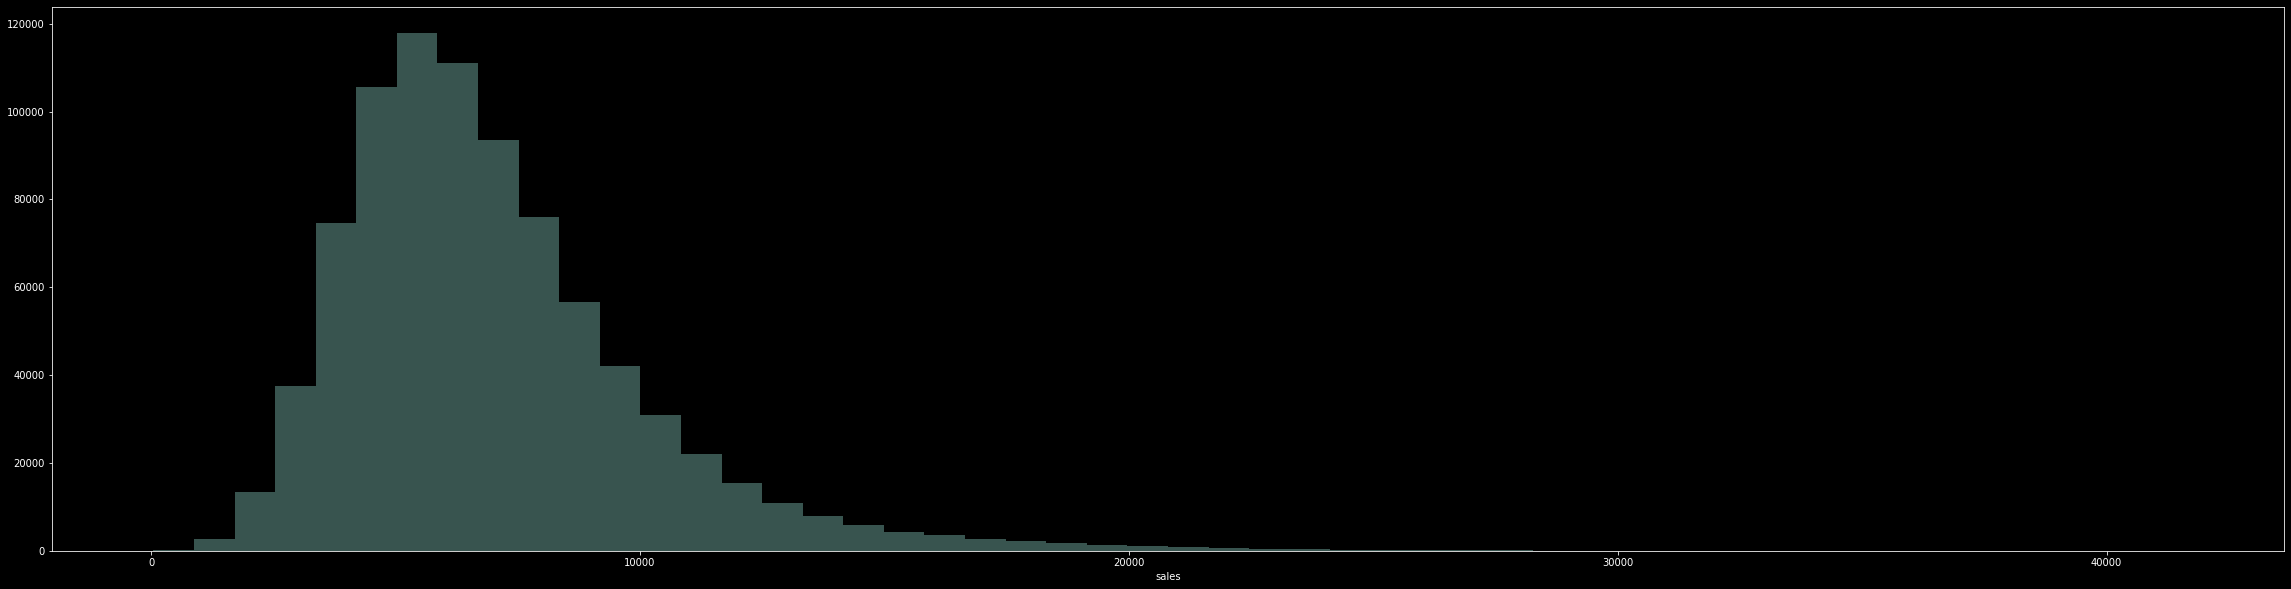

In [50]:
sns.distplot(df4['sales'], kde=False)

### 4.1.2 Variável numérica

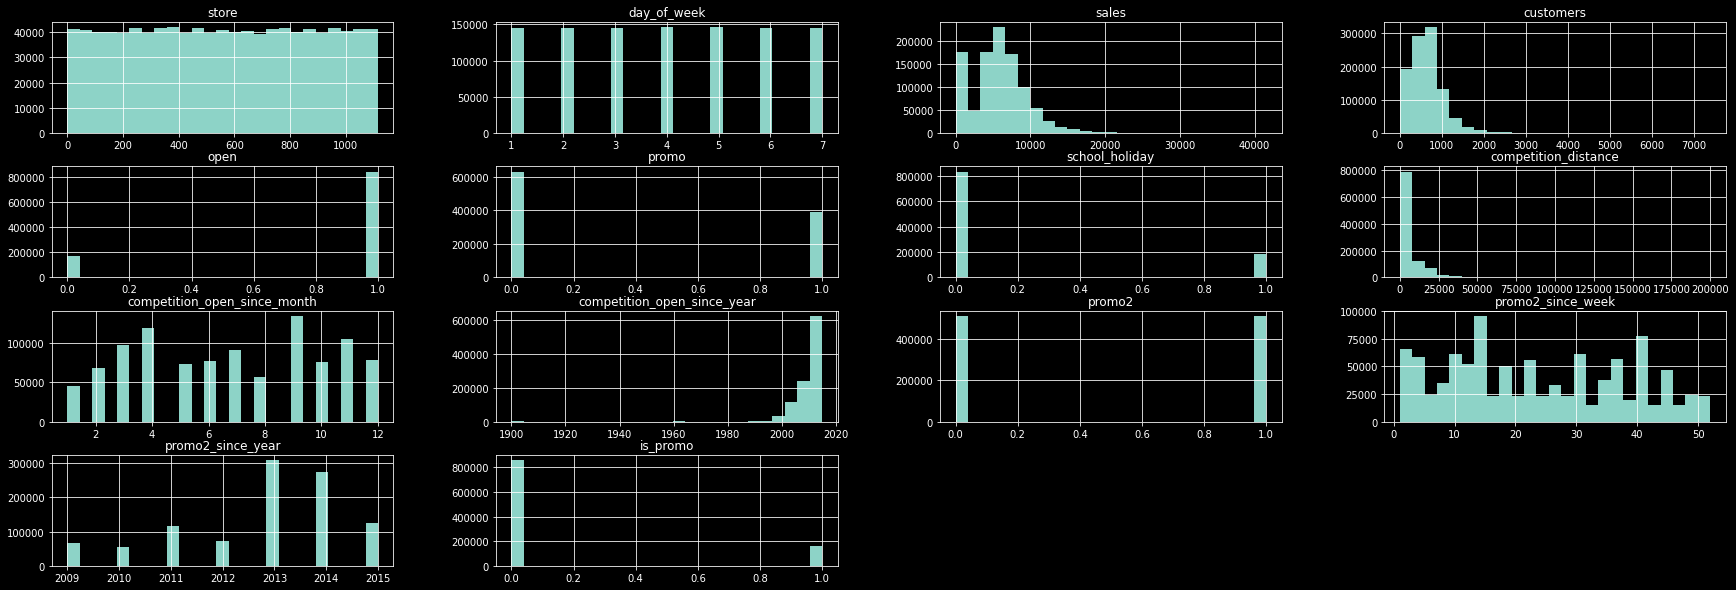

In [58]:
matplotlib.rcParams['figure.figsize'] = (30, 10)
num_attributes.hist(bins=25);

### 4.1.3 Variável categórica

C:\Users\lalaz\Anaconda3\envs\dsproducao\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\lalaz\Anaconda3\envs\dsproducao\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\lalaz\Anaconda3\envs\dsproducao\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  

<AxesSubplot:xlabel='sales', ylabel='Density'>

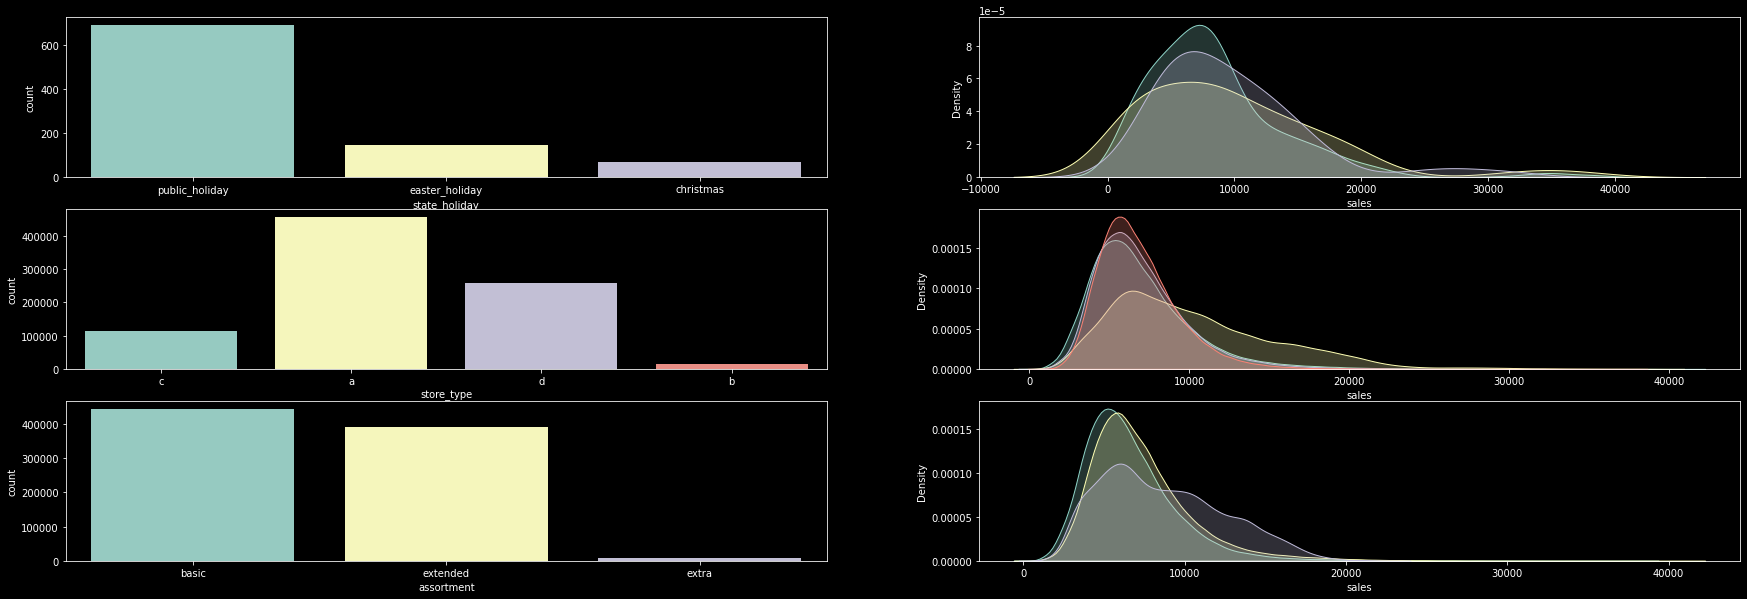

In [59]:
# state_holiday
plt.subplot(3,2,1)
a = df4[ df4['state_holiday'] != 'regular_day' ]
sns.countplot( a['state_holiday'] )

plt.subplot(3,2,2)
sns.kdeplot( df4[ df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True  )
sns.kdeplot( df4[ df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True  )
sns.kdeplot( df4[ df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

# store_type	
plt.subplot(3,2,3)
sns.countplot( df4['store_type'] )

plt.subplot(3,2,4)
sns.kdeplot( df4[ df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[ df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[ df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[ df4['store_type'] == 'd']['sales'], label='d', shade=True )

# assortment
plt.subplot(3,2,5)
sns.countplot( df4['assortment'] )

plt.subplot(3,2,6)
sns.kdeplot( df4[ df4['assortment'] == 'basic']['sales'], label='basic', shade=True,legend=True )
sns.kdeplot( df4[ df4['assortment'] == 'extended']['sales'], label='extended', shade=True, legend=True )
sns.kdeplot( df4[ df4['assortment'] == 'extra']['sales'], label='extra', shade=True, legend=True )

## 4.2 Análise bivariada

### H1: Lojas com maior sortimentos deveriam vender mais
**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS

Text(0.5, 1.0, 'Valor das vendas por assortment')

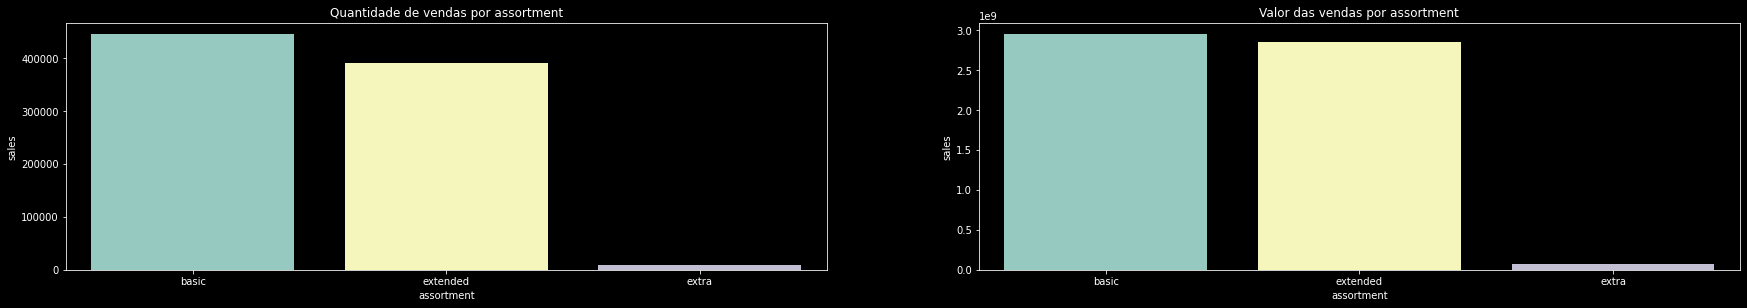

In [60]:
plt.subplot(2,2,1)
aux1 = df4[['assortment', 'sales']].groupby('assortment').count().reset_index()
sns.barplot( data=aux1, y='sales', x='assortment')
plt.title('Sales amount per assortment')

plt.subplot(2,2,2)
aux2 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot( data=aux2, y='sales', x='assortment')
plt.title('Total Sales per assortment')

Text(0.5, 1.0, 'Total Sales per extra assortment')

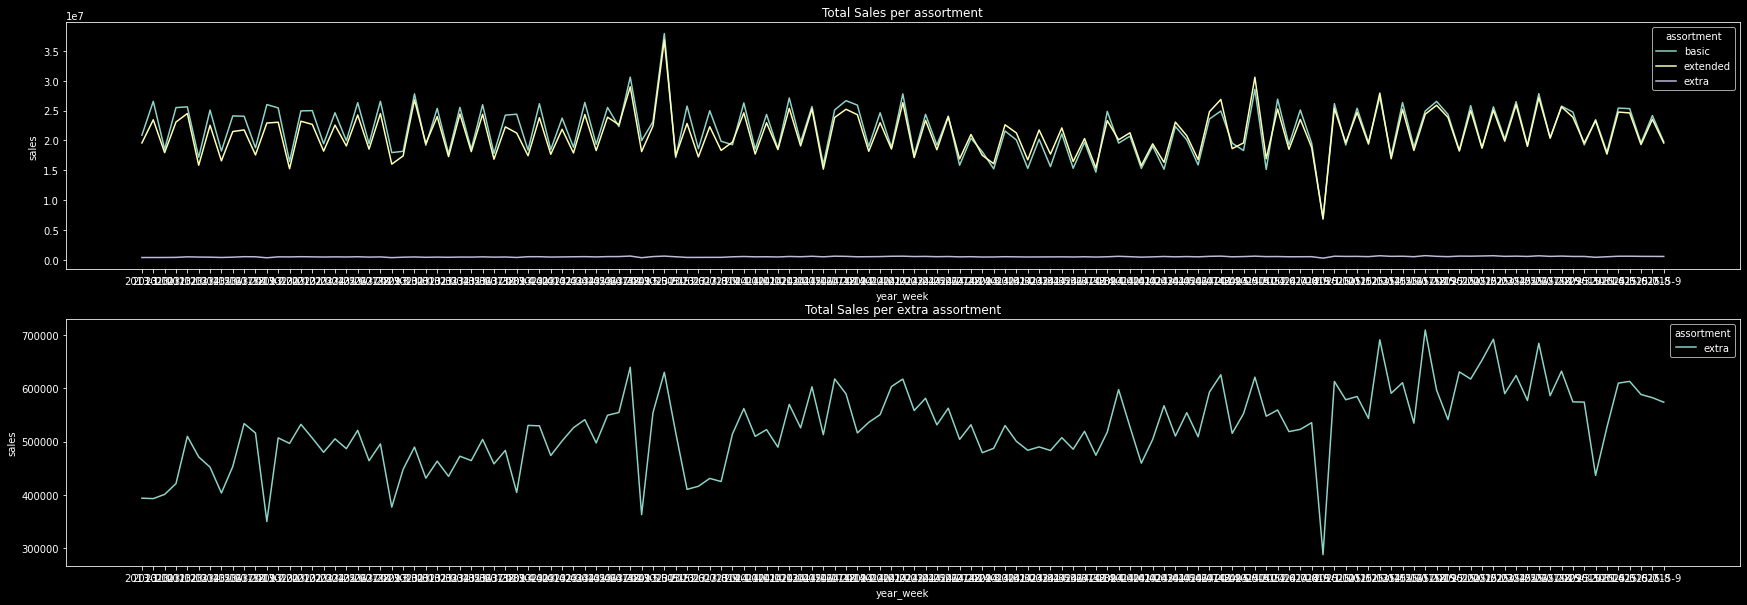

In [63]:
plt.subplot(2,1,1)
aux3 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
sns.lineplot(data=aux3, y='sales', x='year_week', hue='assortment')
plt.title('Total Sales per assortment')

plt.subplot(2,1,2)
aux4 = df4[ df4['assortment'] == 'extra'][['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
sns.lineplot(data=aux4, y='sales', x='year_week', hue='assortment')
plt.title('Total Sales per extra assortment')

### H2: Lojas com competidores mais próximos deveriam vender menos
**FALSO** Lojas com competidores MAIS PRÓXIMOS vendem MAIS

<AxesSubplot:>

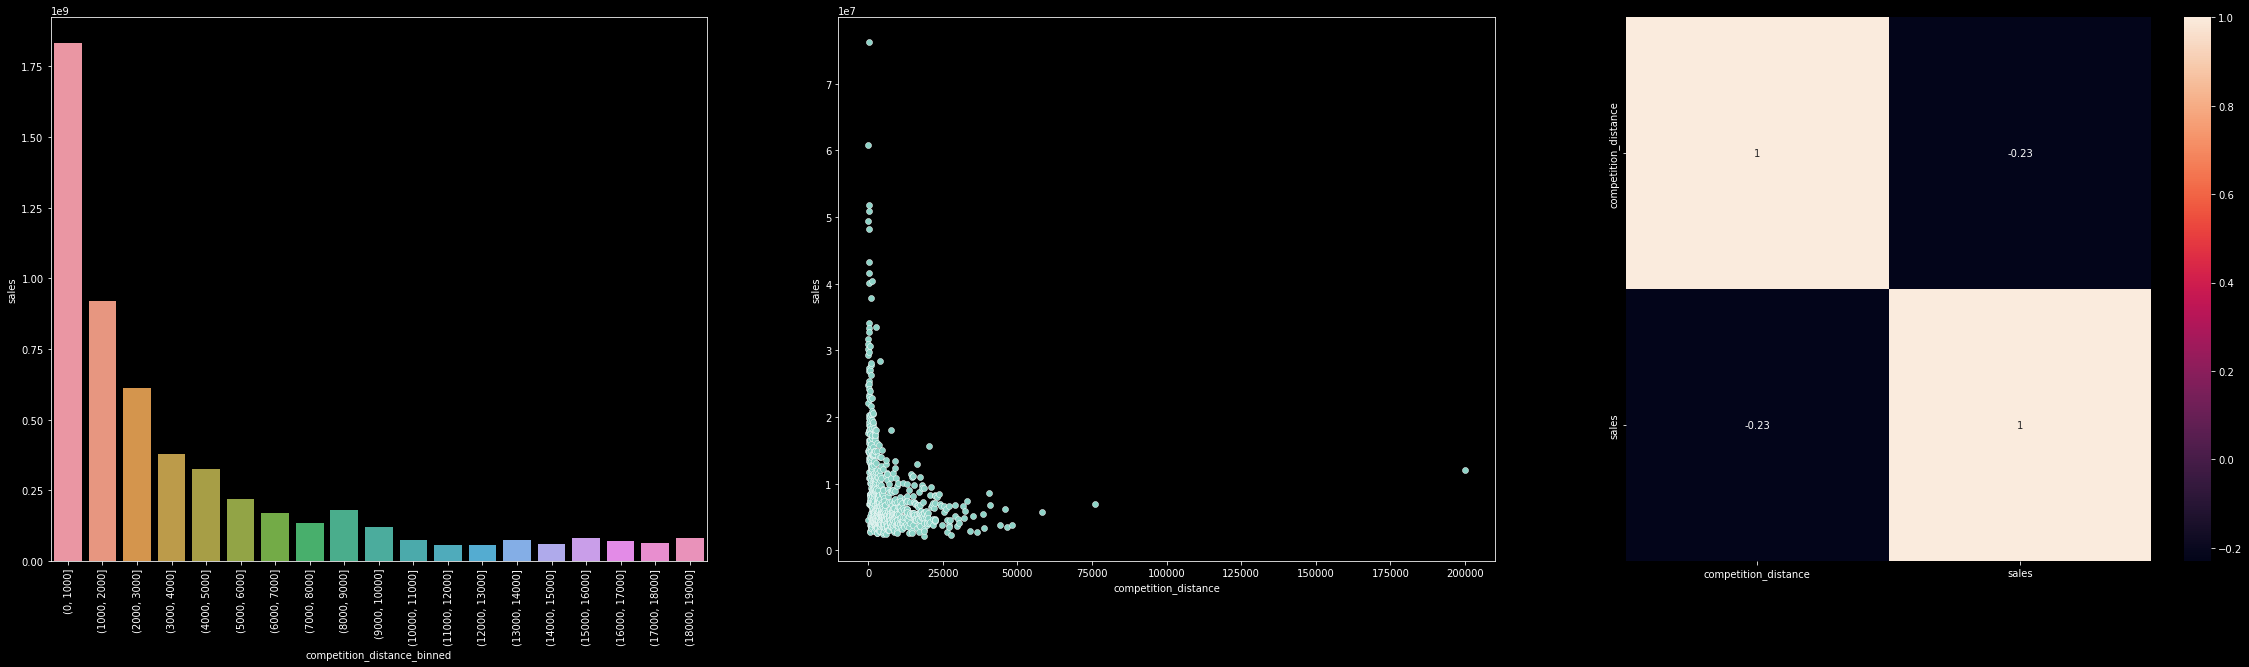

In [64]:
matplotlib.rcParams['figure.figsize'] = (40, 10)

plt.subplot(1,3,1)
aux1 = df4[['competition_distance', 'sales']].groupby(['competition_distance']).sum().reset_index()

bins = list( np.arange(0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )

aux2 = aux1[['competition_distance_binned', 'sales']].groupby(['competition_distance_binned']).sum().reset_index()
sns.barplot(data=aux2, y='sales', x='competition_distance_binned')
plt.xticks( rotation=90 )

plt.subplot(1,3,2)
aux3 = df4[ df4['competition_distance'] <= 70000000 ][['competition_distance', 'sales']].groupby(['competition_distance']).sum().reset_index()
sns.scatterplot(data=aux3, y='sales', x='competition_distance')

plt.subplot(1,3,3)
aux4 = df4[['competition_distance', 'sales']].groupby(['competition_distance']).sum().reset_index()
sns.heatmap( aux4.corr(method='pearson'), annot=True)

### H3: Lojas com competidores à mais tempo deveriam vendem mais
**FALSO** Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS

<AxesSubplot:>

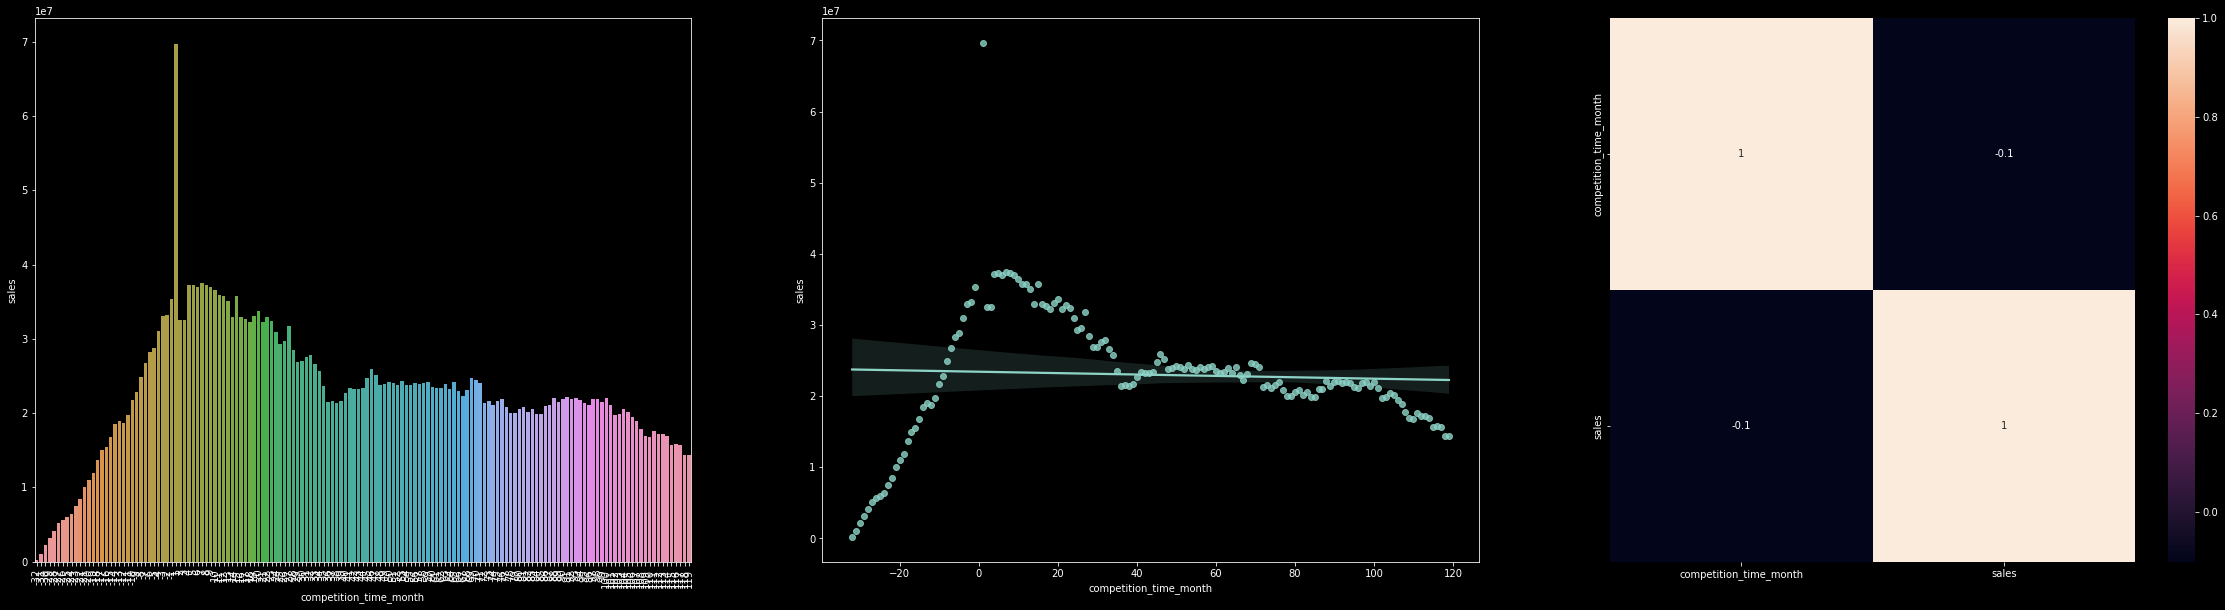

In [65]:
matplotlib.rcParams['figure.figsize'] = (40, 10)

plt.subplot(1,3,1)
aux1 = df4[ (df4['competition_time_month'] < 120) & (df4['competition_time_month'] != 0) ][['competition_time_month', 'sales']].groupby(['competition_time_month']).sum().reset_index()
sns.barplot(data=aux1, y='sales', x='competition_time_month')
plt.xticks( rotation=90 )

plt.subplot(1,3,2)
sns.regplot(data=aux1, y='sales', x='competition_time_month')

plt.subplot(1,3,3)
aux3 = df4[['competition_time_month', 'sales']].groupby(['competition_time_month']).sum().reset_index()
sns.heatmap( aux3.corr(method='pearson'), annot=True )

### H4: Lojas com promoções ativas por mais tempo deveriam vender mais
**FALSO** Lojas com PROMOÇÕES ATIVAS POR MENOS TEMPO vendem MENOS, depois de um certo período de promoção

<AxesSubplot:>

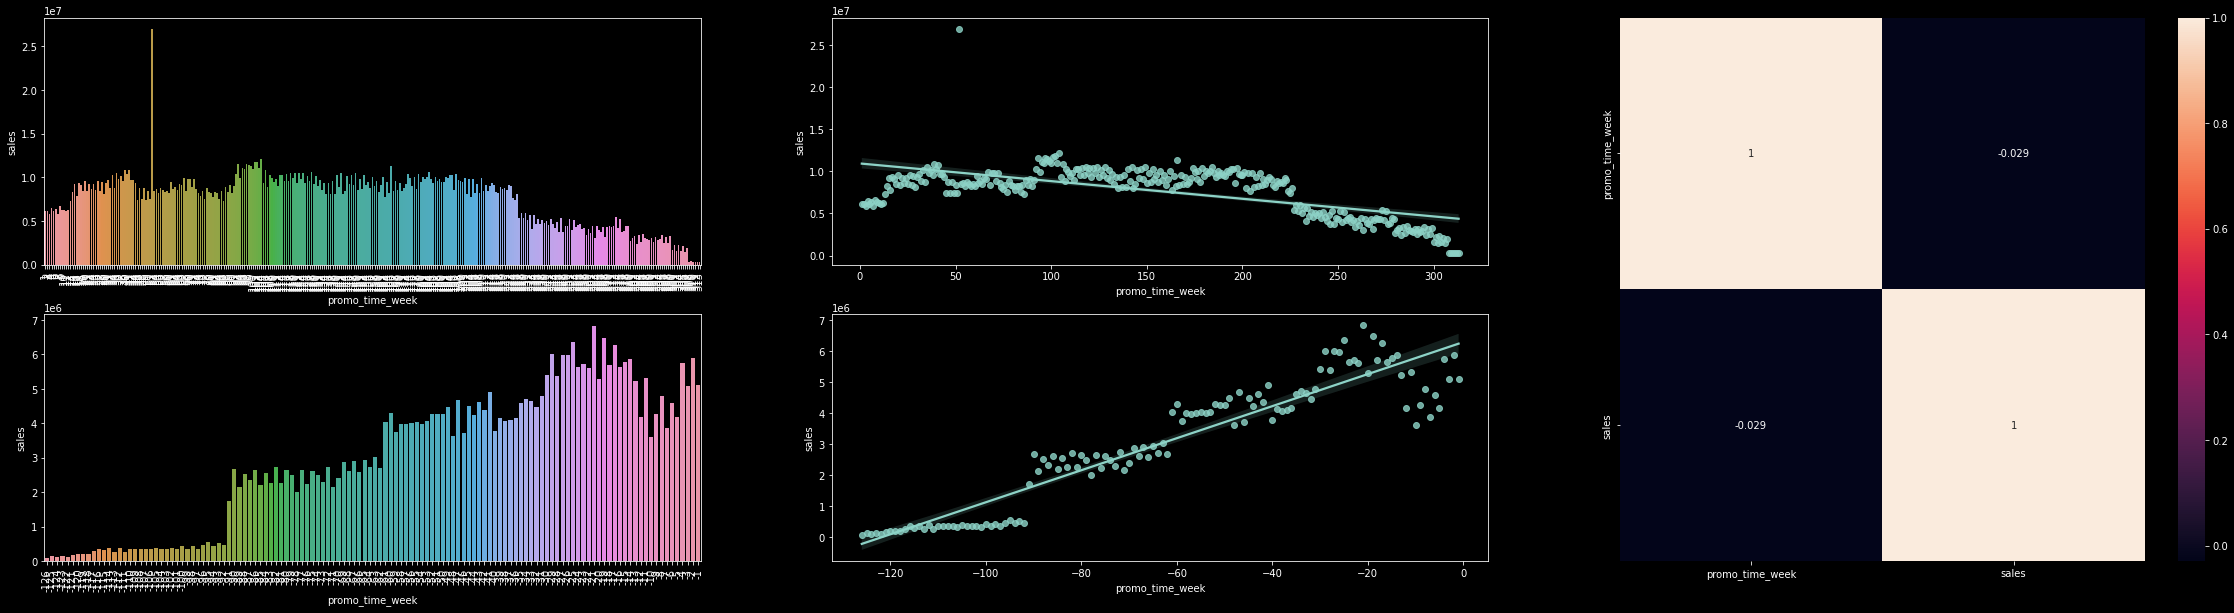

In [66]:
matplotlib.rcParams['figure.figsize'] = (40, 10)

grid = gridspec.GridSpec(2,3)

plt.subplot( grid[0,0] )
aux1 = df4[ (df4['promo_time_week'] > 0) ][['promo_time_week', 'sales']].groupby(['promo_time_week']).sum().reset_index()
sns.barplot(data=aux1, y='sales', x='promo_time_week')
plt.xticks( rotation=90 )

plt.subplot( grid[0,1] )
sns.regplot(data=aux1, y='sales', x='promo_time_week')

plt.subplot( grid[1,0] )
aux2 = df4[ (df4['promo_time_week'] < 0) ][['promo_time_week', 'sales']].groupby(['promo_time_week']).sum().reset_index()
sns.barplot(data=aux2, y='sales', x='promo_time_week')
plt.xticks( rotation=90 )

plt.subplot( grid[1,1] )
sns.regplot(data=aux2, y='sales', x='promo_time_week')

plt.subplot( grid[:,2] )
aux3 = df4[['promo_time_week', 'sales']].groupby(['promo_time_week']).sum().reset_index()
sns.heatmap( aux3.corr(method='pearson'), annot=True )

### H5: Lojas com mais promoções consecutivas deveriam vender mais
**FALSO** Lojas com mais PROMOÇÕES CONSECUTIVAS vendem MENOS

In [67]:
aux1 = df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index().sort_values(by='sales', ascending=False)
aux1

,promo,promo2,sales
2,1,0,1628930532
0,0,0,1482612096
3,1,1,1472275754
1,0,1,1289362241


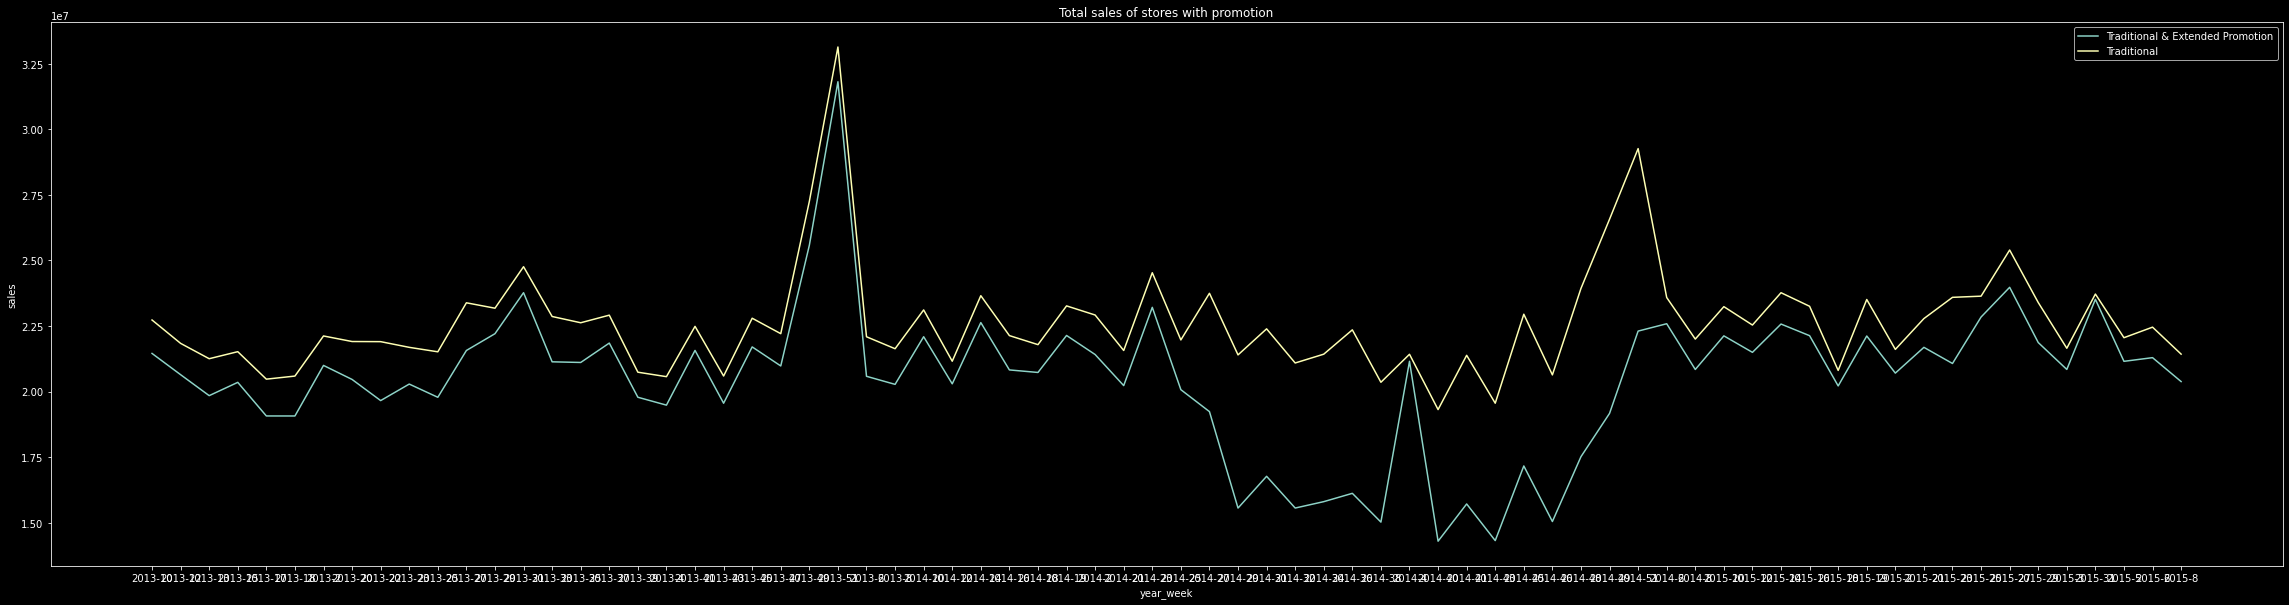

In [70]:
matplotlib.rcParams['figure.figsize'] = (40, 10)

# selecionar lojas com promoções tradicional e extendida
aux2 = df4[ (df4['promo'] == 1) & ( df4['promo2'] == 1) ][['year_week', 'sales']].groupby(['year_week']).sum().reset_index()
ax = sns.lineplot(data=aux2, y='sales', x='year_week')

# selecionar lojas com promoções tradicional somente
aux3 = df4[ (df4['promo'] == 1) & ( df4['promo2'] == 0) ][['year_week', 'sales']].groupby(['year_week']).sum().reset_index()
ax = sns.lineplot(data=aux3, y='sales', x='year_week')
plt.title('Total sales of stores with promotion')

ax.legend( labels = ['Traditional & Extended Promotion', 'Traditional'])

### H6: Lojas abertas durante o feriado de Natal deveriam vender mais
**FALSO** Lojas abertas durante o FERIADO DE NATAL vendem MENOS, comparado com outros feriados

Text(0.5, 1.0, 'Total sales per holiday')

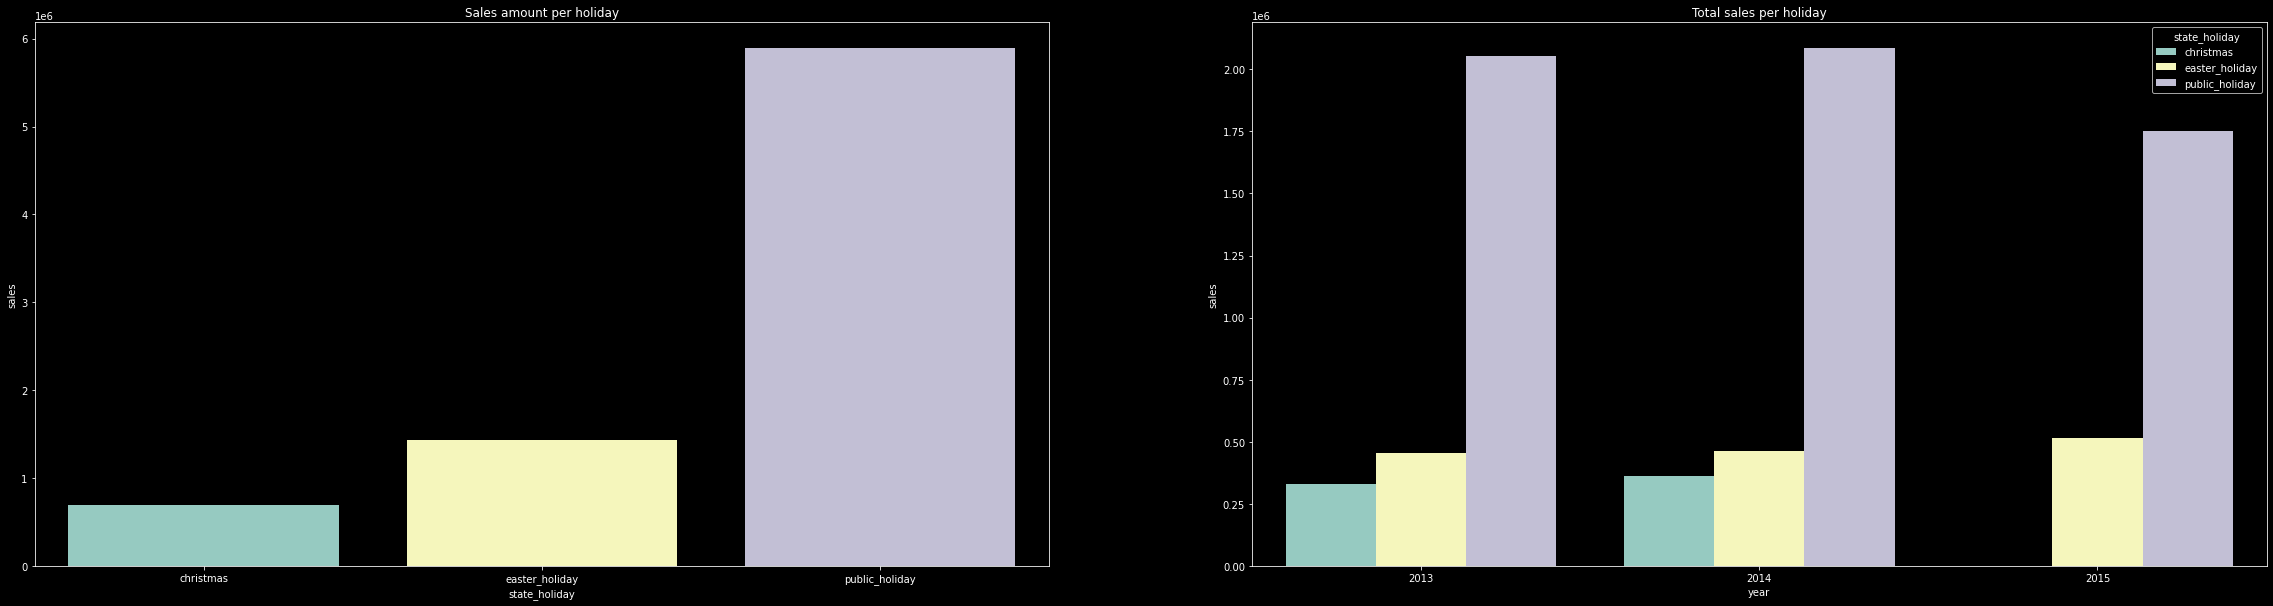

In [161]:
plt.subplot(1,2,1)
aux1 = df4[ df4['state_holiday'] != 'regular_day' ][['state_holiday', 'sales']].groupby(['state_holiday']).sum().reset_index()
sns.barplot(data=aux1, y='sales', x='state_holiday')
plt.title('Sales amount per holiday')

plt.subplot(1,2,2)
aux2 = df4[ df4['state_holiday'] != 'regular_day' ][['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(data=aux2, y='sales', x='year', hue='state_holiday')
plt.title('Total sales per holiday')

### H7: Lojas deveriam vender mais ao longo dos anos
**FALSO** Lojas vendem MENOS AO LONGO DOS ANOS

<AxesSubplot:>

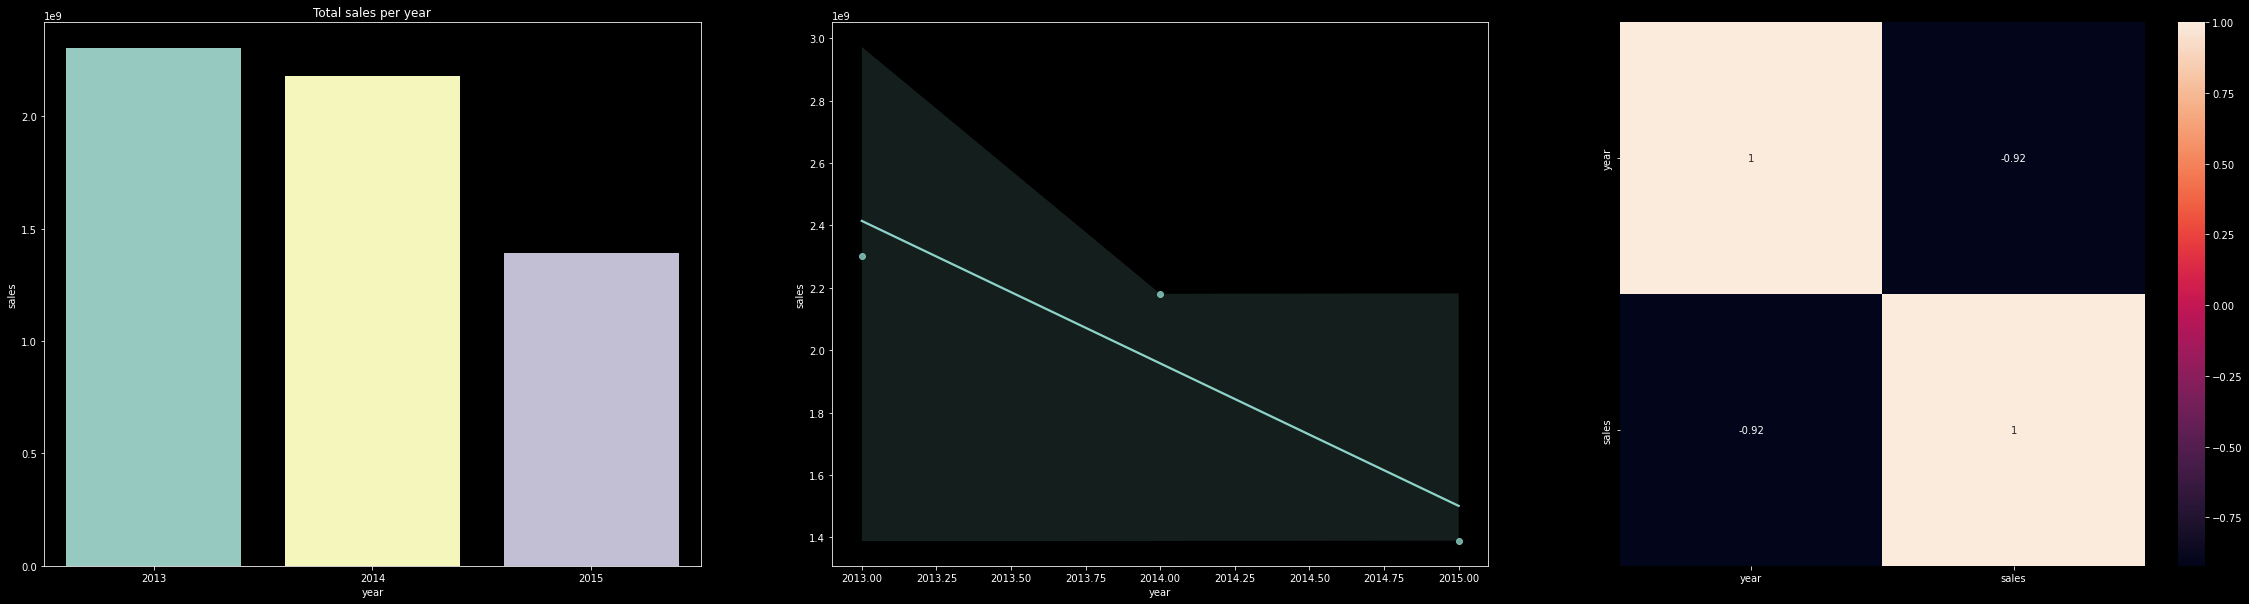

In [162]:
matplotlib.rcParams['figure.figsize'] = (40, 10)

plt.subplot(1,3,1)
aux1 = df4[['year', 'sales']].groupby(['year']).sum().reset_index()
sns.barplot(data=aux1, y='sales', x='year')
plt.title('Total sales per year')

plt.subplot(1,3,2)
sns.regplot(data=aux1, y='sales', x='year')

plt.subplot(1,3,3)
sns.heatmap( aux1.corr(method='pearson'), annot=True )

### H8: Lojas deveriam vender mais no segundo semestre do ano
**VERDADEIRO** Lojas vendem MENOS no SEGUNDO SEMESTRE DO ANO

<AxesSubplot:>

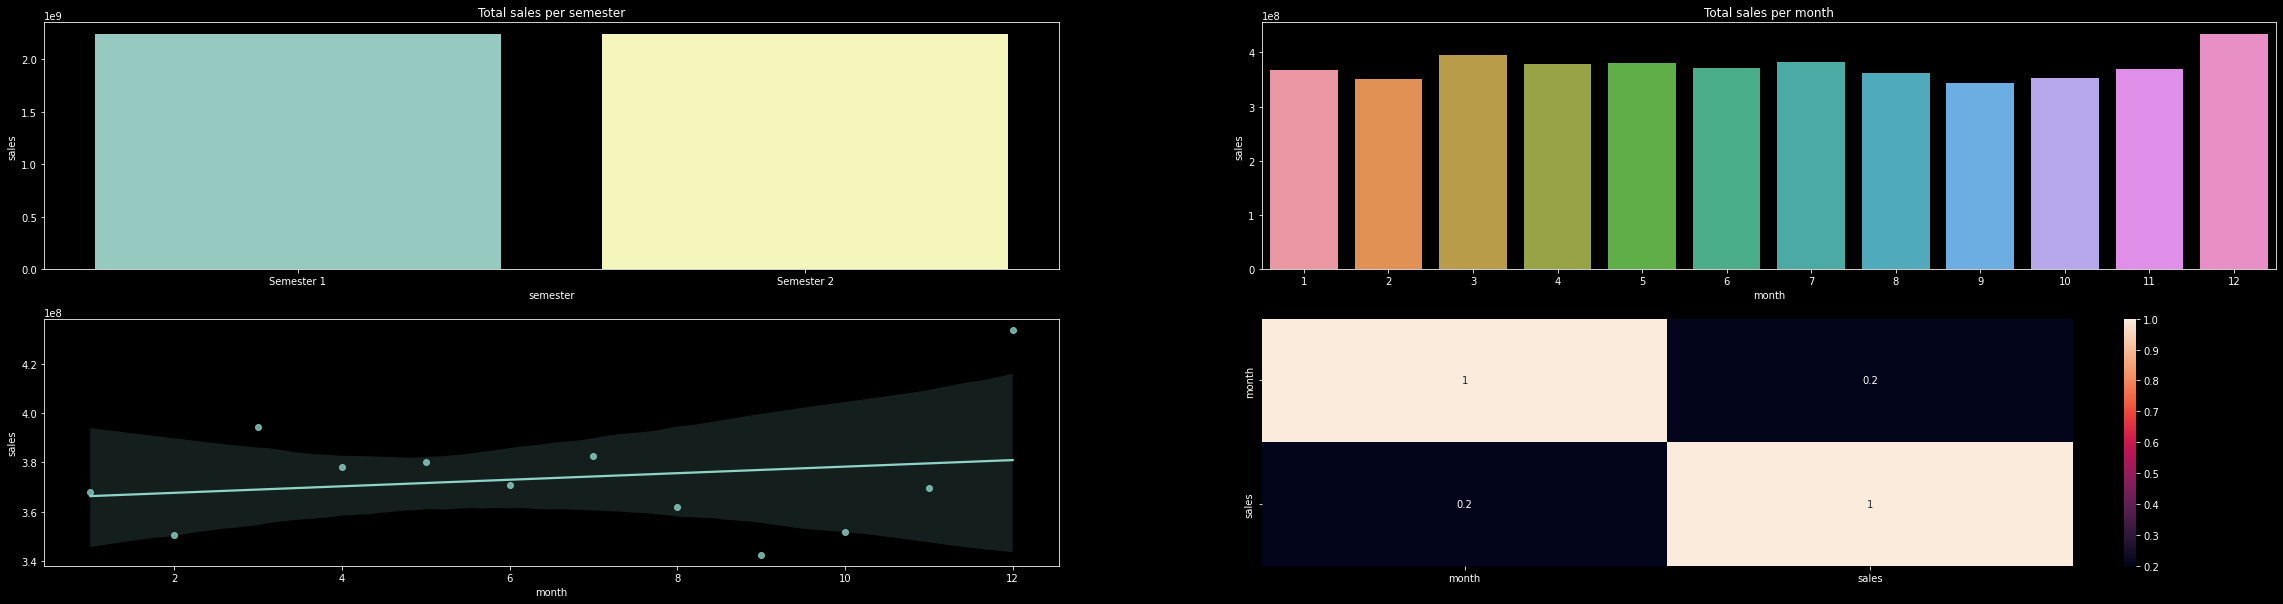

In [159]:
aux1 = df4[ df4['year'] < 2015 ].copy() 
aux1['semester'] = aux1['month'].apply(lambda x: 'Semester 1' if x<=6 else 'Semester 2')

plt.subplot(2,2,1)
aux2 = aux1[['semester', 'sales']].groupby(['semester']).sum().reset_index()
sns.barplot(data=aux2, y='sales', x='semester')
plt.title('Total sales per semester')

plt.subplot(2,2,2)
aux3 = aux1[['month', 'sales']].groupby(['month']).sum().reset_index()
sns.barplot(data=aux3, y='sales', x='month')
plt.title('Total sales per month')

plt.subplot(2,2,3)
sns.regplot(data=aux3, y='sales', x='month')

plt.subplot(2,2,4)
sns.heatmap( aux3.corr(method='pearson'), annot=True )

### H9: Lojas deveriam vender mais depois do dia 10 de cada mês
**VERDADEIRA** Lojas vendem MAIS DEPOIS DO DIA 10 de cada mês

<AxesSubplot:xlabel='before_after', ylabel='sales'>

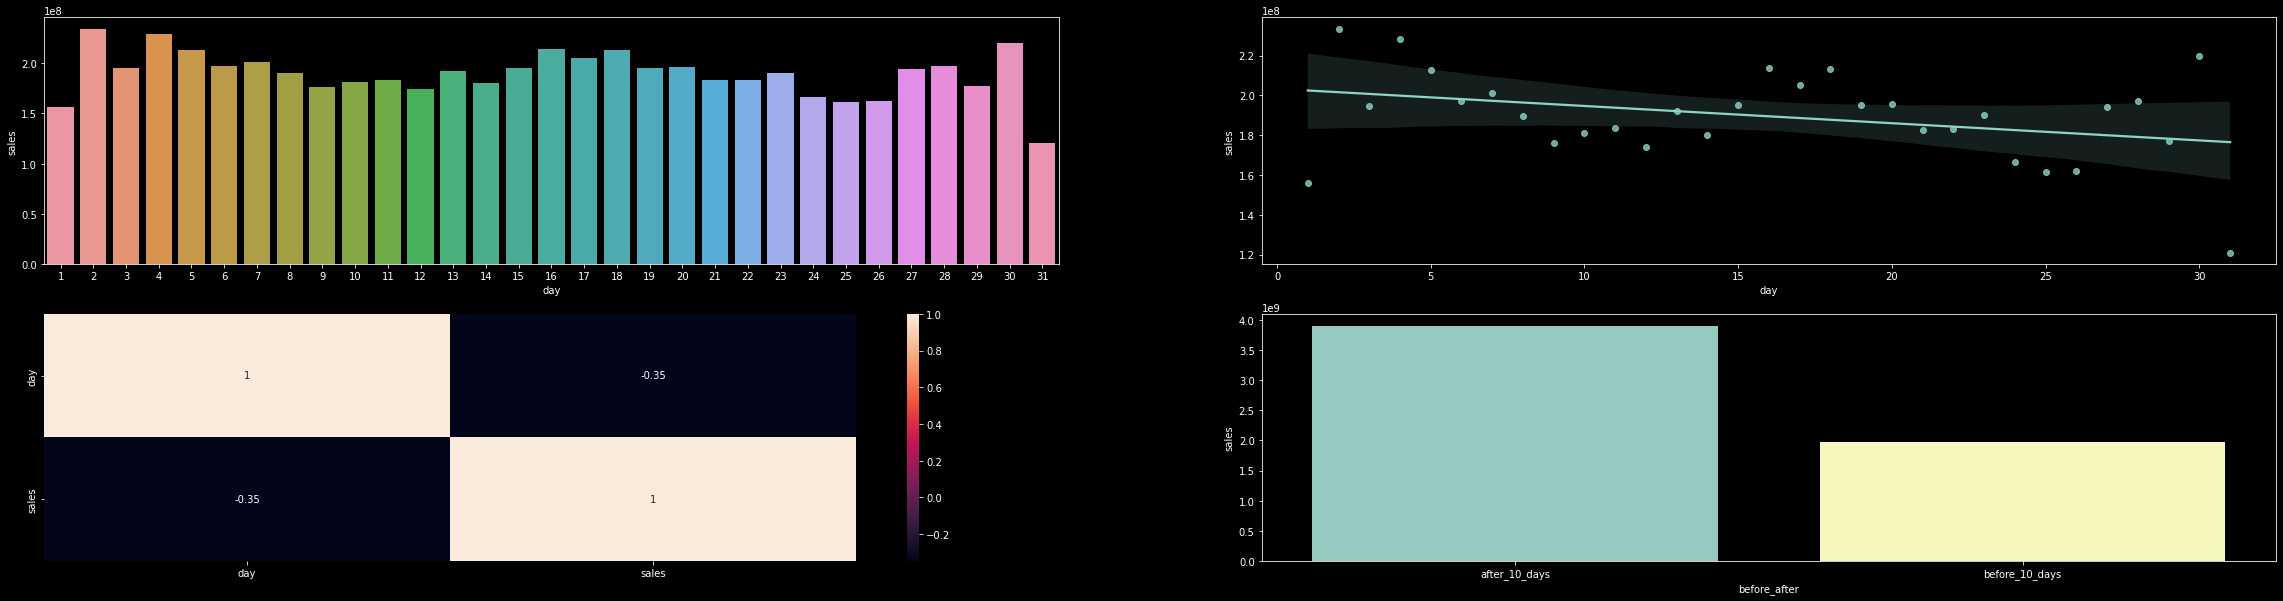

In [76]:
matplotlib.rcParams['figure.figsize'] = (40, 10)

plt.subplot(2,2,1)
aux1 = df4[['day', 'sales']].groupby(['day']).sum().reset_index()
sns.barplot(data=aux1, y='sales', x='day')

plt.subplot(2,2,2)
sns.regplot(data=aux1, y='sales', x='day')

plt.subplot(2,2,3)
sns.heatmap( aux1.corr(method='pearson'), annot=True )

plt.subplot(2,2,4)
aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 = aux1[['before_after', 'sales']].groupby(['before_after']).sum().reset_index()
sns.barplot(data=aux2, y='sales', x='before_after')

### H10: Lojas que abrem ao domingo deveriam vender mais
**VERADEIRA** Lojas que abrem aos domingos vendem em média MAIS

Text(0.5, 1.0, 'Number of stores that open and not open on sunday')

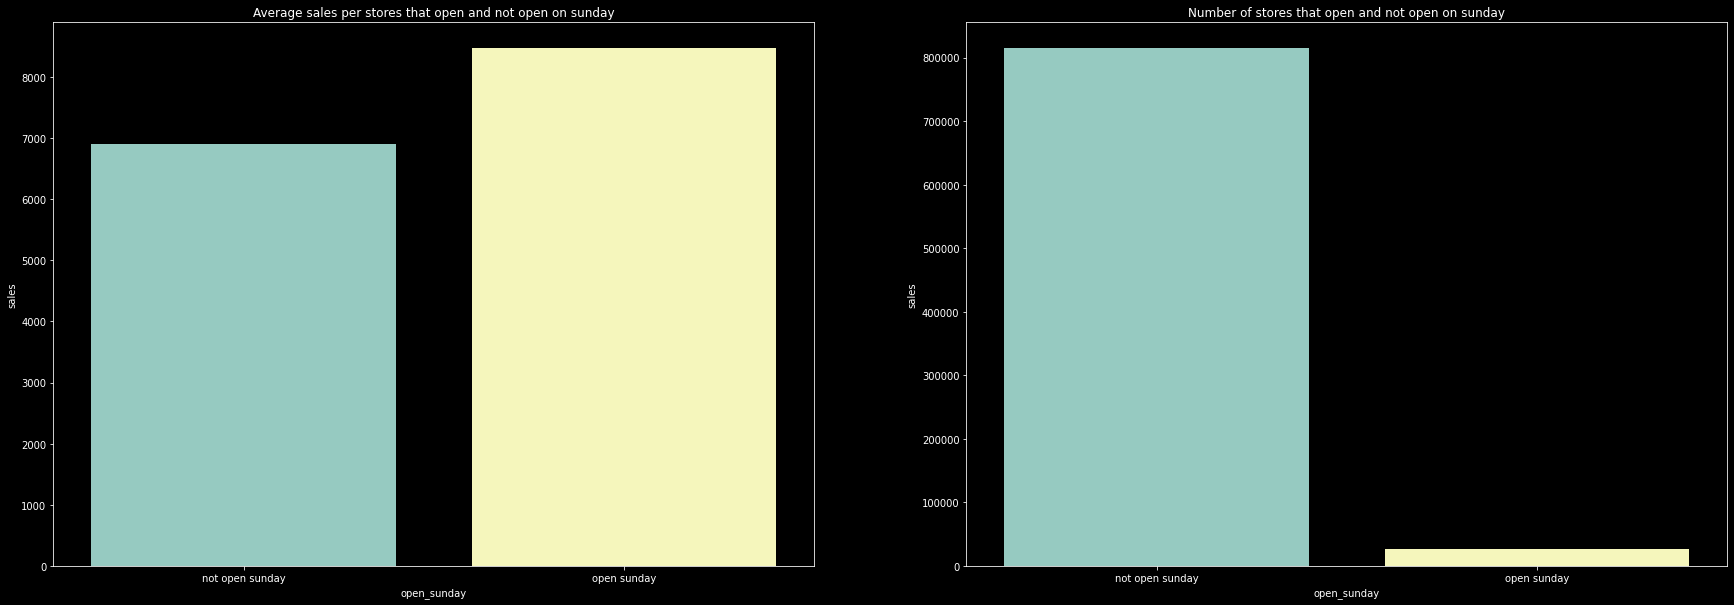

In [153]:
# day_of_week: final de semana = 6 (SAB) e 7 (DOM)

open_weekend = set(df4[ df4['day_of_week']==7 ]['store'])
not_open_weekend = set( df4[~df4['store'].isin(open_weekend)]['store'] )

aux1 = df4.copy()
aux1['open_sunday'] = df4[ df4['day_of_week']!=7 ]['store'].apply( lambda x: 'open sunday' if x in(open_weekend) else 'not open sunday' )

plt.subplot(1,2,1)
aux2 = aux1[['open_sunday', 'sales']].groupby(['open_sunday']).mean().reset_index()
sns.barplot(data=aux2, y='sales', x='open_sunday')
plt.title('Average sales per stores that open and not open on sunday')

plt.subplot(1,2,2)
aux3 = aux1[['open_sunday', 'sales']].groupby(['open_sunday']).count().reset_index()
sns.barplot(data=aux3, y='sales', x='open_sunday')
plt.title('Number of stores that open and not open on sunday')


### H11: Lojas deveriam vender menos durante os feriados escolares
**VERDADEIRO** Lojas vendem MENOS durante os FERIADOS ESCOLARES, exceto para o mês de Agosto

<AxesSubplot:xlabel='month', ylabel='sales'>

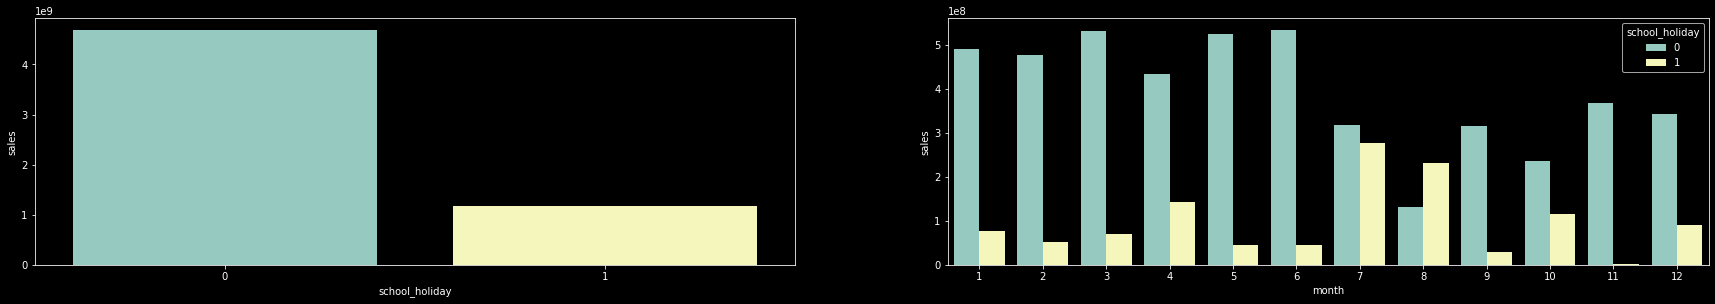

In [152]:
matplotlib.rcParams['figure.figsize'] = (30, 10)

plt.subplot(2,2,1)
aux1 = df4[['school_holiday', 'sales']].groupby(['school_holiday']).sum().reset_index()
sns.barplot(data=aux1, y='sales', x='school_holiday')

plt.subplot(2,2,2)
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(data=aux2, y='sales', x='month', hue='school_holiday')

### Resumo das Hipóteses

In [160]:
tab =[['Hipóteses', 'Conclusão', 'Relevância'],
      ['H1', 'Falsa', 'Baixa'],  
      ['H2', 'Falsa', 'Media'],  
      ['H3', 'Falsa', 'Media'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', 'Falsa', 'Baixa'],
      ['H6', 'Falsa', 'Media'],
      ['H7', 'Falsa', 'Alta'],
      ['H8', 'Verdadeira', 'Baixa'],
      ['H9', 'Verdadeira', 'Alta'],
      ['H10', 'Falsa', 'Alta'],
      ['H11', 'Verdadeira', 'Baixa'],
     ]  
print( tabulate( tab, headers='firstrow' ) )

Hipóteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           Falsa        Baixa
H6           Falsa        Media
H7           Falsa        Alta
H8           Verdadeira   Baixa
H9           Verdadeira   Alta
H10          Falsa        Alta
H11          Verdadeira   Baixa


## 4.3 Análise multivariada

### 4.3.1 Numerical Attributes

**Método de Pearson**: utilizado para calcular a correlação entre duas variáveis numéricas

<AxesSubplot:>

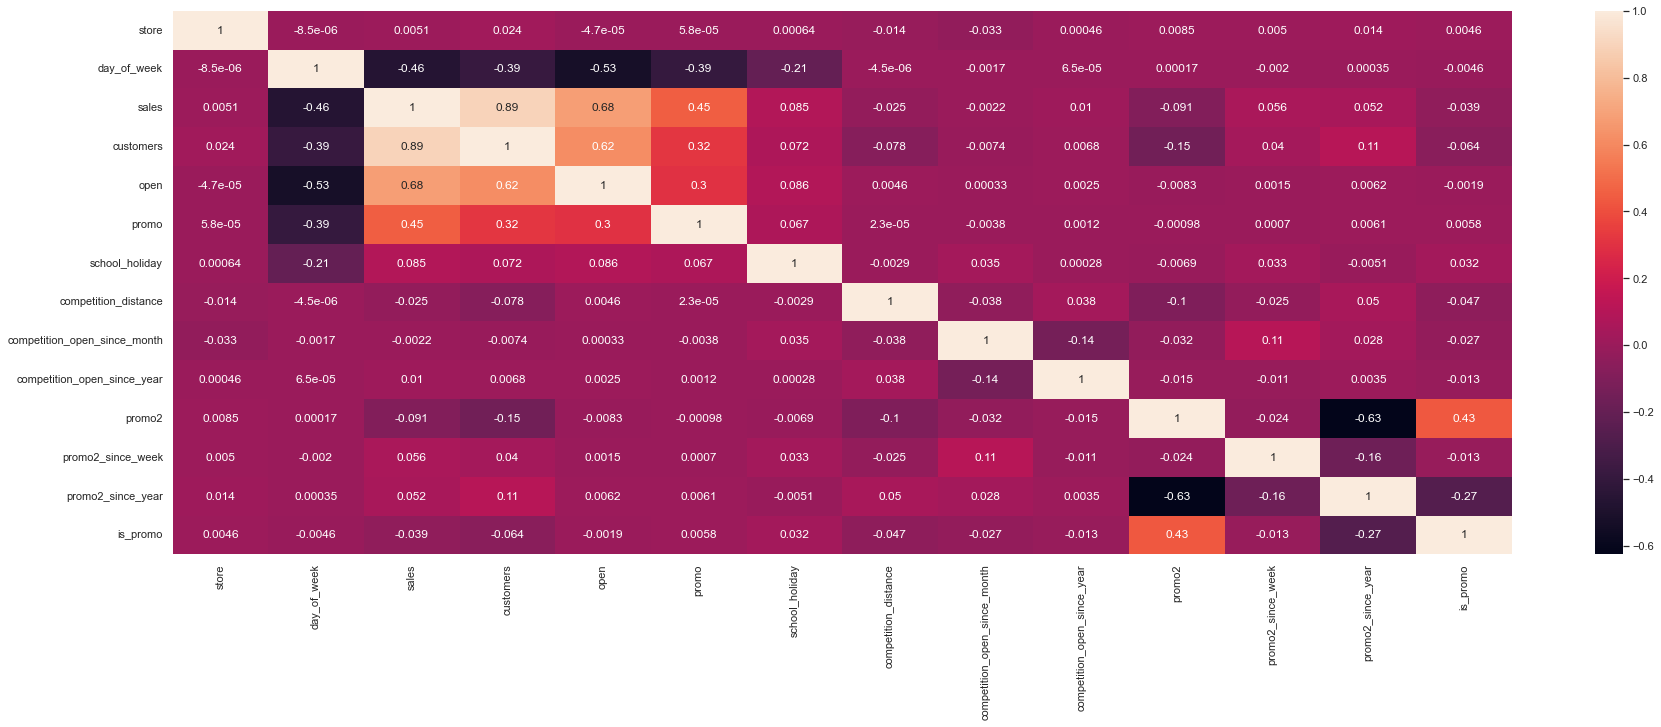

In [111]:
matplotlib.rcParams['figure.figsize'] = (30, 10)

correlation = num_attributes.corr( method='pearson')
sns.heatmap( correlation, annot=True )

### 4.3.2 Categorical Attributes

**Cramer V**: utilizado para calcular a correlação entre duas variáveis categóricas. Fórmula utilizada nesse [link]('https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V').


In [163]:
# only categorical data
cat_attributes = df4.select_dtypes( include='object' )

# calculate cramer v
a1 = cramer_v( cat_attributes['state_holiday'], cat_attributes['state_holiday'] )
a2 = cramer_v( cat_attributes['state_holiday'], cat_attributes['store_type'] )
a3 = cramer_v( cat_attributes['state_holiday'], cat_attributes['assortment'] )

a4 = cramer_v( cat_attributes['store_type'], cat_attributes['state_holiday'] )
a5 = cramer_v( cat_attributes['store_type'], cat_attributes['store_type'] )
a6 = cramer_v( cat_attributes['store_type'], cat_attributes['assortment'] )

a7 = cramer_v( cat_attributes['assortment'], cat_attributes['state_holiday'] )
a8 = cramer_v( cat_attributes['assortment'], cat_attributes['store_type'] )
a9 = cramer_v( cat_attributes['assortment'], cat_attributes['assortment'] )

# final dataset
d = pd.DataFrame(
    {
        'state_holiday': [a1, a2, a3],
        'store_type': [a4, a5, a6],
        'assortment': [a7, a8, a9],
    }
)

d = d.set_index(d.columns)

<AxesSubplot:>

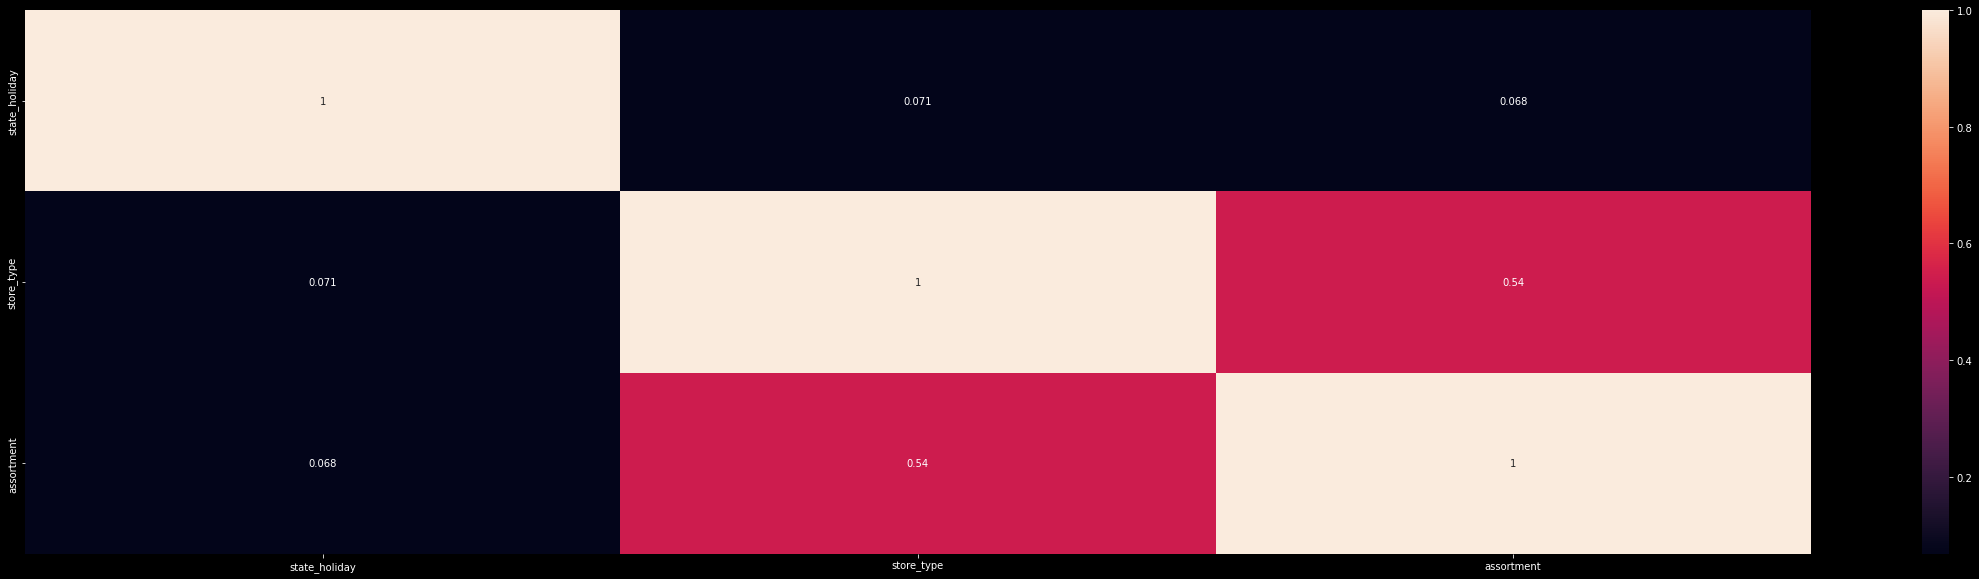

In [164]:
sns.heatmap( d, annot=True )

# 5. Data Preparation

In [177]:
df5 = df4.copy()

## 5.1 Normalização

Não existem variáveis numéricas com distribuição normal no nosso dataset. Então não vamos aplicar normalização para nenhuma variável.

## 5.2 Rescaling

### 5.2.1 Verificar se existem outliers

<AxesSubplot:xlabel='promo_time_week'>

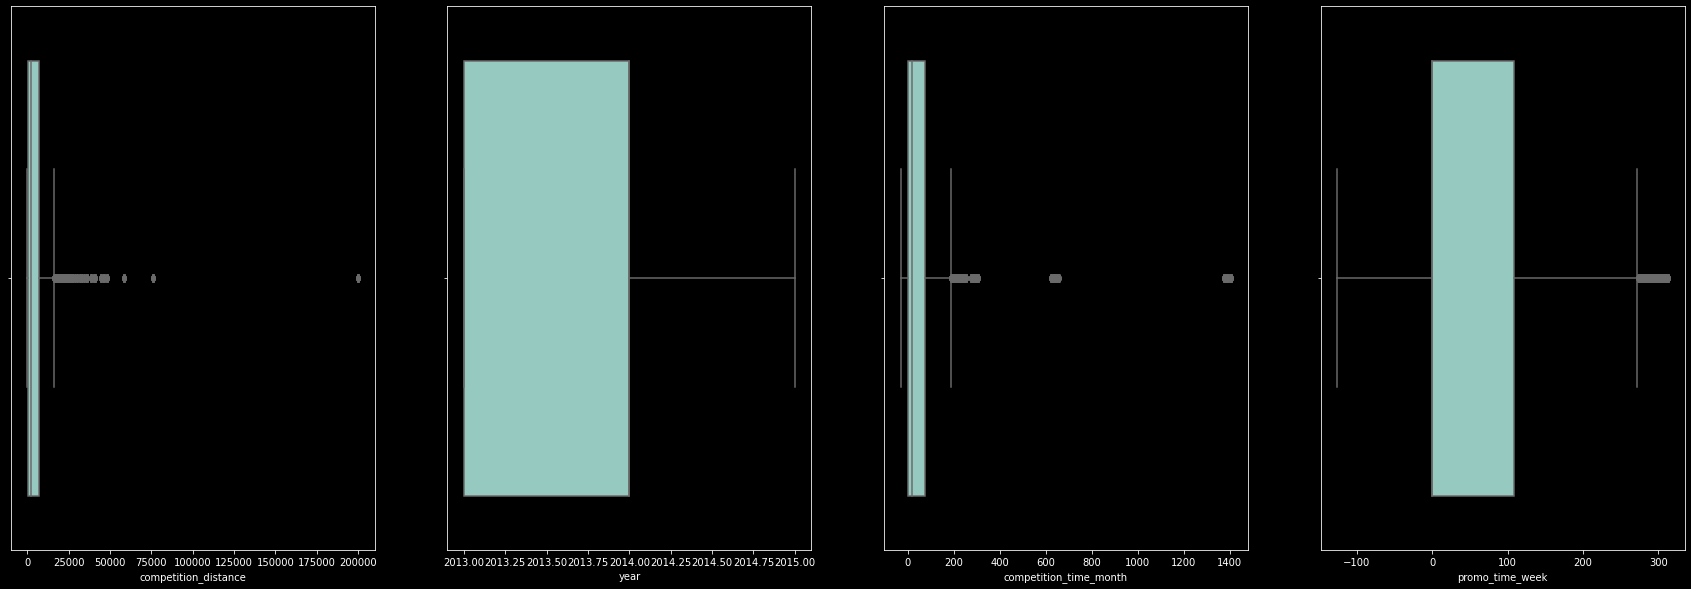

In [178]:
matplotlib.rcParams['figure.figsize'] = (30, 10)

plt.subplot(1,4,1)
sns.boxplot( data=df5, x='competition_distance' )

plt.subplot(1,4,2)
sns.boxplot( data=df5, x='year' )

plt.subplot(1,4,3)
sns.boxplot( data=df5, x='competition_time_month' )

plt.subplot(1,4,4)
sns.boxplot( data=df5, x='promo_time_week' )

In [179]:
rs = RobustScaler()
mms = MinMaxScaler()

path = r'G:\My Drive\courses\comunidads-ds\dsproducao\parameter'

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump(rs, open( os.path.join(path, 'competition_distance_scaler.pkl'), 'wb') )

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump(rs, open( os.path.join(path, 'competition_time_month_scaler.pkl'), 'wb') )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump(mms, open( os.path.join(path, 'year_scaler.pkl'), 'wb') )

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump(mms, open( os.path.join(path, 'promo_time_week_scaler.pkl'), 'wb') )

C:\Users\lalaz\Anaconda3\envs\dsproducao\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

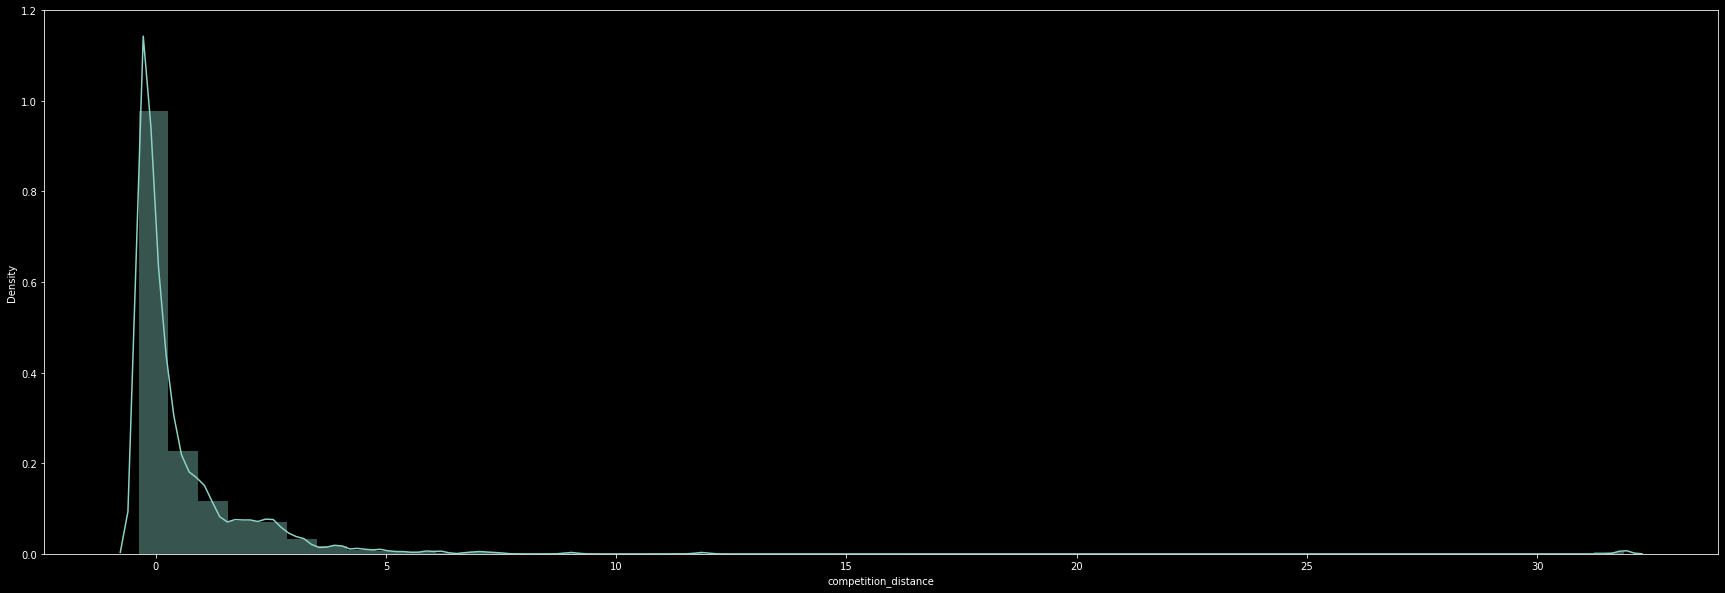

In [180]:
sns.distplot( df5['competition_distance'] )

## 5.3 Transformation

### 5.3.1 Encoding

#### 5.3.1.1 One Hot Encoding

In [181]:
# state_holiday
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,c,basic,-0.170968,9,...,31,2015-31,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,a,basic,-0.283871,11,...,31,2015-31,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,a,basic,1.903226,12,...,31,2015-31,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,c,extended,-0.275806,9,...,31,2015-31,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,a,basic,4.448387,4,...,31,2015-31,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


#### 5.3.1.2 Label Encoding

In [182]:
# store_type
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump(le, open( os.path.join(path, 'store_type_scaler.pkl'), 'wb') )
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,basic,-0.170968,9,...,31,2015-31,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,basic,-0.283871,11,...,31,2015-31,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,basic,1.903226,12,...,31,2015-31,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,extended,-0.275806,9,...,31,2015-31,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,basic,4.448387,4,...,31,2015-31,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


#### 5.3.1.3 Ordinal Encoding

In [183]:
# assortment
assortiment_dict = {'basic': 1,'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortiment_dict )
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,...,31,2015-31,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,...,31,2015-31,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,...,31,2015-31,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,...,31,2015-31,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,...,31,2015-31,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


### 5.3.2 Target Variable Transformation

Vamos aplicar uma transformaçao logarítmica para deixar a distribuição da variável target sales mais próximo de uma normal.

In [184]:
df5['sales'] = np.log1p( df5['sales'] )

C:\Users\lalaz\Anaconda3\envs\dsproducao\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

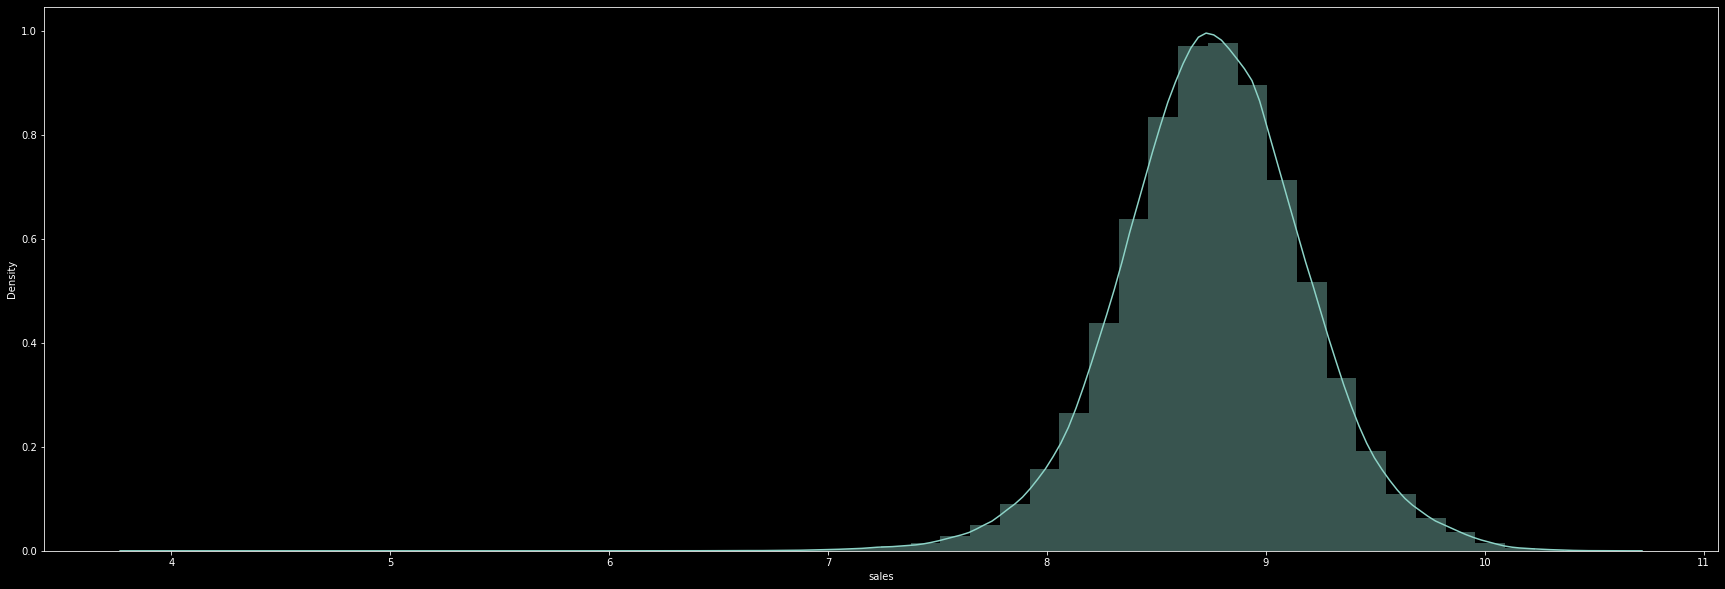

In [186]:
sns.distplot( df5['sales'] )

### 5.3.3 Cyclical Nature Transformation

In [187]:
# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2 * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2 * np.pi/30 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2 * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2 * np.pi/12 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2 * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2 * np.pi/52 ) ) )

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2 * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2 * np.pi/7 ) ) )

In [188]:
df5.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,8.568646,8.71029,9.025816,9.546527,8.481151
promo,1,1,1,1,1
school_holiday,1,1,1,1,1
store_type,2,0,0,2,0
assortment,1,1,1,3,1
competition_distance,-0.170968,-0.283871,1.903226,-0.275806,4.448387
competition_open_since_month,9,11,12,9,4


# 6. Feature Selection

In [189]:
df6 = df5.copy()

## 6.1 Split dataframe into training and test dataset

In [190]:
cols_drop = ['day', 'month', 'week_of_year', 'week_of_year', 'day_of_week', 
             'day_of_week', 'year_week', 'promo_since', 'competition_since' ]

df6 = df6.drop( cols_drop, axis=1 )

In [191]:
# Identificar o primeiro das últimas 6 semanas com base na última data de venda
last_6_weeks = df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta( days=6*7 )

print( 'Fist day of the last 6 weeks: {}'.format( last_6_weeks ) )

Fist day of the last 6 weeks: 2015-06-19 00:00:00


In [192]:
# O dataset de treino irá contemplar as vendas realizadas até as últimas 6 semanas
X_train = df6[ df6['date'] < last_6_weeks ]
y_train = X_train['sales']

# O dataset de teste irá contemplar as vendas realizadas nas últimas 6 semanas
X_test = df6[ df6['date'] >= last_6_weeks ]
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( 'Test Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00
Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 Boruta as feature selector

In [ ]:
# # training and test dataset for Boruta
# X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values

# # transform series in vector (array)
# y_train_n = y_train.values.ravel()

# # define RandomForestRegressor
# rf = RandomForestRegressor( n_jobs=-1 )

# # define boruta
# # utilizar o algoritmo de Random Forest para cálculo da importância das features
# boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n)

In [302]:
# # fornece como resultado o valor corresponte ao rank de importância da feature
# cols_selected = boruta.support_.tolist()

# # best features
# X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# # not selected boruta
# cols_not_selected_boruta = np.setdiff1d( X_train_fs.columns, cols_selected_boruta )

## 6.3 Manual feature selection

In [193]:
cols_not_selected_boruta = [
    'is_promo', 
    'month_sin', 
    'school_holiday',
    'state_holiday_christmas', 
    'state_holiday_easter_holiday',
    'state_holiday_public_holiday', 
    'state_holiday_regular_day',
    'week_of_year_sin', 
    'year'   
]

In [194]:
# armazenar variáveis em lista para não precisar rodar novamente o boruta
# Vamos considerar também 2 variáveis não selecionadas pelo boruta, 
# mas que resolvi considerar devido aos resultados da análise exploratória (month_sin e week_of_year_sin)
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_sin',
    'day_cos',
    'month_sin',
    'month_cos',
    'week_of_year_sin',
    'week_of_year_cos',
    'day_of_week_sin',
    'day_of_week_cos'
]


# e também as variáveis date e sale
feat_to_add = ['date', 'sales']

cols_selected_full = cols_selected_boruta.copy()
cols_selected_full.extend( feat_to_add )

In [135]:
cols_selected_full

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_sin',
 'day_cos',
 'month_sin',
 'month_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'date',
 'sales']

# 7. Machine Learning Modelling

In [195]:
x_train = X_train[ cols_selected_boruta ] 
x_test =  X_test[ cols_selected_boruta ]

## 7.1 Average Model

O modelo de médias é o modelo mais simples possível. Ele irá servir como baseline para sabermos de houve uma melhora ou não na performance quando utilizamos outros algoritmos.

Para aplicar o modelo nesse nosso caso, vamos calcular a média das vendas por loja. O resultado disso, vamos armazenar na variável yhat_baseline.

In [328]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename( columns={'sales': 'predictions'})
aux1 = pd.merge( aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
# precisamos aplicar a exponencial na variável target vendas
# porque na etapa de Análise Exploratória, nós aplicamos o logarítmo para deixar a sua distribuição mais próxima de uma normal
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression Model

In [331]:
# model
lr = LinearRegression().fit( x_train, y_train)

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1(y_test), np.expm1(yhat_lr) )
lr_result


,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


O RMSE do Linear Regression Model é maior que o RMSE do Average Model. Isso quer dizer que para esse caso o Average Model teve uma performance melhor e que os dados possuem um comportamento complexo, não linaer. Então, muito provavelmente, modelos lineares não conseguirão descrever bem esse fenômeno. Por isso precisamos testar modelos não lineares.

### 7.2.1 Linear Regression Model - Cross Validation

In [426]:
x_training = X_train[ cols_selected_full ]

lr_result_cv = cross_validation(x_training=x_training, 
                                kfold=5, 
                                model_name='Linear Regression',
                                model=lr,
                                verbose=False 
                                )

In [427]:
lr_result_cv[0]

,Model Name,MAE,MAPE,RMSE,iteration
0,Linear Regression,2646.810012,0.311373,3821.901006,5
0,Linear Regression,1908.471091,0.328253,2576.457764,4
0,Linear Regression,1803.980723,0.304078,2522.910455,3
0,Linear Regression,2069.335138,0.285533,3001.334290,2
0,Linear Regression,1980.039151,0.283893,2840.000319,1


In [428]:
lr_result_cv[1]

,MAE,MAPE,RMSE
Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3 Linear Regression Regularized Model - Lasso

In [334]:
# model
lrr = Lasso( alpha=0.0001 ).fit( x_train, y_train)

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr) )
lrr_result

C:\Users\lalaz\Anaconda3\envs\dsproducao\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20898.183288731583, tolerance: 14.55484543773816
  positive)


,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1867.907526,0.291894,2675.988565


### 7.3.1 Lasso - Cross Validation

In [429]:
x_training = X_train[ cols_selected_full ]

lrr_result_cv = cross_validation(x_training=x_training, 
                                 kfold=5, 
                                 model_name='Lasso',
                                 model=lrr,
                                 verbose=False 
                                )

C:\Users\lalaz\Anaconda3\envs\dsproducao\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17959.031892888885, tolerance: 11.172204265513638
  positive)
C:\Users\lalaz\Anaconda3\envs\dsproducao\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17298.59942238684, tolerance: 11.937395279075506
  positive)
C:\Users\lalaz\Anaconda3\envs\dsproducao\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18972.313292118502, tolerance: 12.565835453461386
  positive)
C:\Users\lalaz\Anaconda3\envs\dsproducao\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not con

In [430]:
lrr_result_cv[0]

,Model Name,MAE,MAPE,RMSE,iteration
0,Lasso,2652.078213,0.311447,3829.253683,5
0,Lasso,1900.526832,0.325671,2573.305567,4
0,Lasso,1802.126052,0.302664,2524.738645,3
0,Lasso,2071.246007,0.284726,3007.570081,2
0,Lasso,1982.222863,0.283521,2844.661150,1


In [431]:
lrr_result_cv[1]

,MAE,MAPE,RMSE
Lasso,2081.64 +/- 298.77,0.3 +/- 0.02,2955.91 +/- 471.18


## 7.4 Random Forest Regressor

In [338]:
# model
# n_jobs=-1 -> para rodar em paralelo
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train)

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.920696,0.099853,1009.951206


### 7.4.1 Random Forest Regression - Cross Validation

In [432]:
x_training = X_train[ cols_selected_full ]

rf_result_cv = cross_validation(x_training=x_training, 
                                 kfold=5, 
                                 model_name='Random Forest Regressor',
                                 model=rf,
                                 verbose=True
                                )


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


In [433]:
rf_result_cv[0]

,Model Name,MAE,MAPE,RMSE,iteration
0,Random Forest Regressor,1206.168493,0.149762,1785.218229,5
0,Random Forest Regressor,882.691585,0.136087,1335.177671,4
0,Random Forest Regressor,550.961267,0.088351,855.361862,3
0,Random Forest Regressor,853.006864,0.109172,1304.225615,2
0,Random Forest Regressor,697.024841,0.097362,1004.499361,1


In [434]:
rf_result_cv[1]

,MAE,MAPE,RMSE
Random Forest Regressor,837.97 +/- 219.11,0.12 +/- 0.02,1256.9 +/- 320.13


## 7.5 XGBoost Regressor

In [435]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100, 
                              eta=0.01, 
                              max_depth=10, 
                              subsample=0.7,
                              colsample_bytee=0.9 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,863.61623,0.125748,1277.615621


### 7.5.1 XGBoost Regressor - Cross Validation

In [436]:
x_training = X_train[ cols_selected_full ]

xgb_result_cv = cross_validation(x_training=x_training, 
                                 kfold=5, 
                                 model_name='XGBoost Regressor',
                                 model=model_xgb,
                                 verbose=True
                                )


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


In [445]:
xgb_result_cv[0]

,Model Name,MAE,MAPE,RMSE,iteration
0,XGBoost Regressor,1373.259088,0.184440,1937.823550,5
0,XGBoost Regressor,958.101706,0.143451,1360.691092,4
0,XGBoost Regressor,796.891138,0.122670,1161.808534,3
0,XGBoost Regressor,1079.663995,0.139114,1609.662546,2
0,XGBoost Regressor,969.756944,0.130577,1391.062872,1


In [455]:
xgb_result_cv[1]

,MAE,MAPE,RMSE
XGBoost Regressor,1035.53 +/- 191.46,0.14 +/- 0.02,1492.21 +/- 264.22


## 7.6 Compare Model's Performance

### 7.6.1. Single Performance

In [456]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE,iteration
0,Random Forest Regressor,678.920696,0.099853,1009.951206,NaN
0,XGBoost Regressor,863.616230,0.125748,1277.615621,NaN
0,Average Model,1354.800353,0.455051,1835.135542,NaN
0,Linear Regression - Lasso,1867.907526,0.291894,2675.988565,NaN
0,Linear Regression,1980.039151,0.283893,2840.000319,1.0


### 7.6.2 Real Performance - Time Series Cross Validation

In [457]:
modelling_result_cv = pd.concat( [lr_result_cv[1], lrr_result_cv[1], rf_result_cv[1], xgb_result_cv[1]] )
modelling_result_cv.sort_values( by='RMSE' )

,MAE,MAPE,RMSE
Random Forest Regressor,837.97 +/- 219.11,0.12 +/- 0.02,1256.9 +/- 320.13
XGBoost Regressor,1035.53 +/- 191.46,0.14 +/- 0.02,1492.21 +/- 264.22
Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
Lasso,2081.64 +/- 298.77,0.3 +/- 0.02,2955.91 +/- 471.18


Apesar do Random Forest ter apresentado uma melhor performance, para os próximos passos, vamos seguir com a implementação do modelo XGBoost Regressor.

# 8. Hyperparameter Fine Tuning

## 8.1 Random Search

In [459]:
import random
import warnings
warnings.filterwarnings( 'ignore' )

In [473]:
# param = {
#     'n_estimators': [1500, 1700, 2500, 3000, 3500],
#     #'n_estimators': [15, 17, 25, 30, 35],
#     'eta': [0.01, 0.03],
#     'max_depth': [3, 5, 9],
#     'subsample': [0.1, 0.5, 0.7],
#     'colsample_bytee': [0.3, 0.7, 0.9],
#     'min_child_weight': [3, 8, 15]
#     }

# MAX_EVAL = 10

In [474]:
# final_result = pd.DataFrame()

# for i in range( MAX_EVAL ):
    
#     # choose values for parameters randomly
#     hp = { k: random.sample( v, 1)[0] for k, v in param.items() }
#     print( hp )
        
#     # model
#     model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                 n_estimators=hp['n_estimators'], 
#                                 eta=hp['eta'],  
#                                 max_depth=hp['max_depth'], 
#                                 subsample=hp['subsample'], 
#                                 colsample_bytee=hp['colsample_bytee'],
#                                 min_child_weight=hp['min_child_weight'] )

#     # performance
#     result = cross_validation(  x_training=x_training, 
#                                 kfold=2, 
#                                 model_name='XGBoost Regressor',
#                                 model=model_xgb, 
#                                 verbose=False)
    
#     final_result = pd.concat( [final_result, result[1]] )  
    
# final_result


{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytee': 0.7, 'min_child_weight': 15}
{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytee': 0.3, 'min_child_weight': 3}
{'n_estimators': 2500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytee': 0.7, 'min_child_weight': 3}
{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytee': 0.9, 'min_child_weight': 8}
{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytee': 0.3, 'min_child_weight': 15}
{'n_estimators': 1500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytee': 0.3, 'min_child_weight': 15}
{'n_estimators': 1500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytee': 0.3, 'min_child_weight': 8}
{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytee': 0.9, 'min_child_weight': 15}
{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 3, 'subsamp

,MAE,MAPE,RMSE
XGBoost Regressor,975.14 +/- 92.96,0.13 +/- 0.01,1391.36 +/- 154.77
XGBoost Regressor,902.18 +/- 93.96,0.12 +/- 0.01,1274.83 +/- 165.23
XGBoost Regressor,980.57 +/- 82.99,0.13 +/- 0.01,1403.12 +/- 145.96
XGBoost Regressor,881.23 +/- 85.79,0.12 +/- 0.01,1268.06 +/- 149.74
XGBoost Regressor,838.32 +/- 84.56,0.11 +/- 0.01,1218.42 +/- 158.7
XGBoost Regressor,1092.62 +/- 61.62,0.15 +/- 0.0,1573.54 +/- 112.9
XGBoost Regressor,1090.6 +/- 73.46,0.15 +/- 0.0,1563.8 +/- 130.22
XGBoost Regressor,953.74 +/- 85.13,0.13 +/- 0.01,1360.49 +/- 145.95
XGBoost Regressor,981.99 +/- 78.67,0.13 +/- 0.01,1403.83 +/- 137.42
XGBoost Regressor,903.04 +/- 95.62,0.12 +/- 0.01,1274.87 +/- 167.17


## 8.2 Final Model

In [197]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 9,
    'subsample': 0.5,
    'colsample_bytee': 0.3,
    'min_child_weight': 15 
    }

In [201]:
# loading model
home_path = r'G:\My Drive\courses\comunidads-ds\dsproducao\model'
model_xgb_tuned = pickle.load( open( os.path.join( home_path, 'model_rossmann.pkl'), 'rb') )

In [202]:
# model
# model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
#                                     n_estimators=param_tuned['n_estimators'], 
#                                     eta=param_tuned['eta'],  
#                                     max_depth=param_tuned['max_depth'], 
#                                     subsample=param_tuned['subsample'], 
#                                     colsample_bytee=param_tuned['colsample_bytee'],
#                                     min_child_weight=param_tuned['min_child_weight'] 
#                                   ).fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( model_name='XGBoost Regressor', 
                             y = np.expm1(y_test), 
                             yhat = np.expm1(yhat_xgb_tuned) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,641.895406,0.092747,934.240456


In [ ]:
# save model in a file
path = r'G:\My Drive\courses\comunidads-ds\dsproducao\model'
pickle.dump(model_xgb_tuned, open( os.path.join(path, 'model_rossmann.pkl'), 'wb') )

In [204]:
mpe = mean_percentage_error( np.expm1(y_test) , np.expm1(yhat_xgb_tuned) )
mpe

0.007175823694550095

O MPE é positivo. Isso quer dizer que o modelo está overfitando, ou seja, ele está fazendo mais predições acima do que abaixo do valor real.

# 9. Error Interpretation

In [205]:
df9 = X_test[ cols_selected_full ].copy()

# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

## 9.1 Business Performance

In [228]:
# sum of predictions
df9_aux = df9[ ['store', 'sales', 'predictions']].groupby('store').sum().reset_index()

# MAE
df9_aux1 = df9[ ['store', 'sales', 'predictions'] ].groupby('store').apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] )).reset_index()
df9_aux1.rename( columns={ 0: 'MAE'}, inplace=True )

# MAPE
df9_aux2 = df9[ ['store', 'sales', 'predictions'] ].groupby('store').apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] )).reset_index()
df9_aux2.rename( columns={ 0: 'MAPE'}, inplace=True )

# merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df9_aux3 = pd.merge( df9_aux3, df9_aux, how='inner', on='store' )

# scenarios
df9_aux3['worst_scenario'] = df9_aux3['predictions'] - df9_aux3['MAE']
df9_aux3['best_scenario'] = df9_aux3['predictions'] + df9_aux3['MAE']

# order columns
df9_aux3 = df9_aux3[ ['store', 'sales', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE', ] ]

In [226]:
df9_aux3.sort_values( 'MAPE', ascending=False ).head()

,store,sales,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,137966.0,106729.640625,103407.555497,110051.725753,3322.085128,0.556587
908,909,360069.0,249640.781250,242283.662322,256997.900178,7357.118928,0.513778
875,876,257556.0,196201.578125,192211.767822,200191.388428,3989.810303,0.290287
182,183,188887.0,197121.359375,195623.188351,198619.530399,1498.171024,0.243619
721,722,279296.0,343124.781250,341397.358702,344852.203798,1727.422548,0.232737


<AxesSubplot:xlabel='store', ylabel='MAPE'>

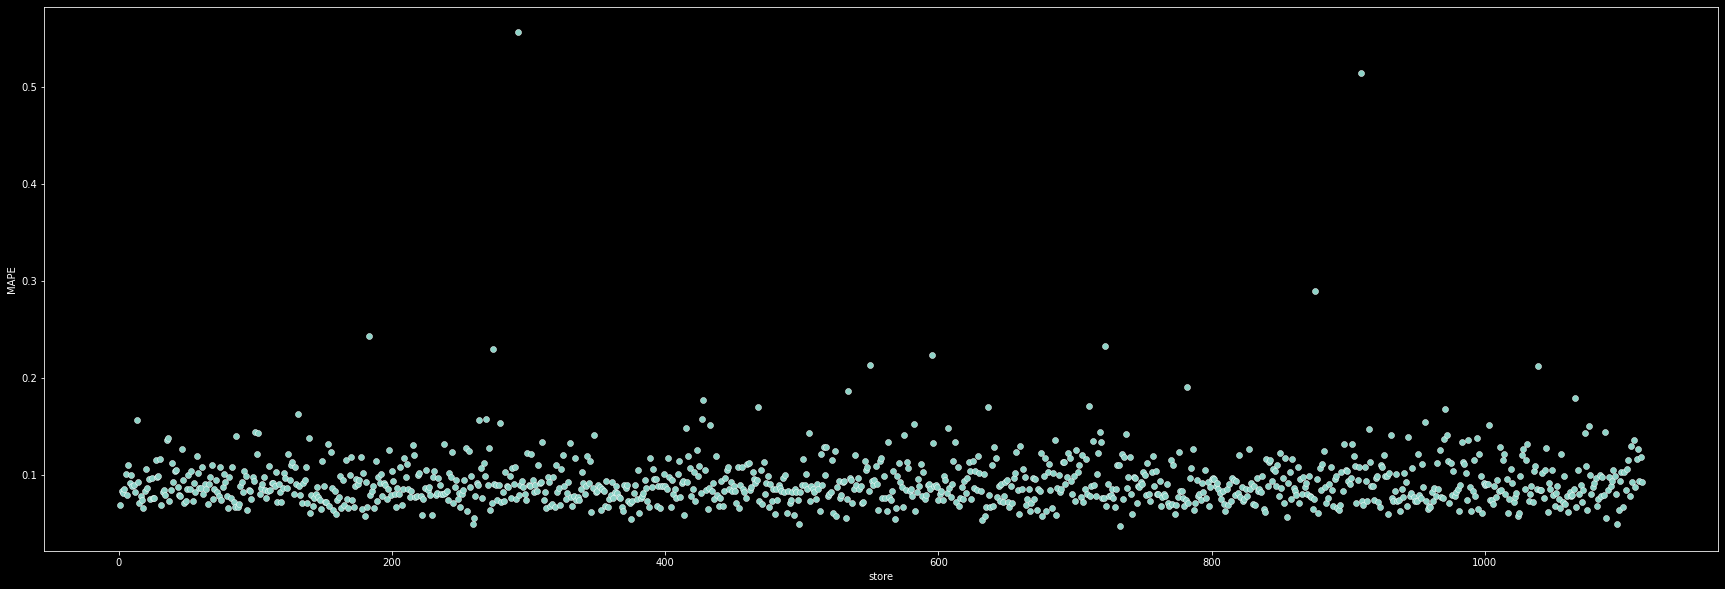

In [208]:
sns.scatterplot( data=df9_aux3, x='store', y='MAPE' )

## 9.2 Total Performance

In [209]:
df9_aux4 = df9_aux3[ ['predictions', 'worst_scenario', 'best_scenario'] ].apply( lambda x: np.sum(x), axis=0 ).reset_index()
df9_aux4.rename( columns={ 'index': 'scenarios', 0: 'values'}, inplace=True )
df9_aux4['values'] = df9_aux4['values'].map( 'R${:,.2f}'.format )
df9_aux4

,scenarios,values
0,predictions,"R$283,665,248.00"
1,worst_scenario,"R$282,945,505.54"
2,best_scenario,"R$284,385,008.68"


## 9.3 Machine Learning Performance

In [210]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

C:\Users\lalaz\Anaconda3\envs\dsproducao\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\lalaz\Anaconda3\envs\dsproducao\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='predictions', ylabel='error'>

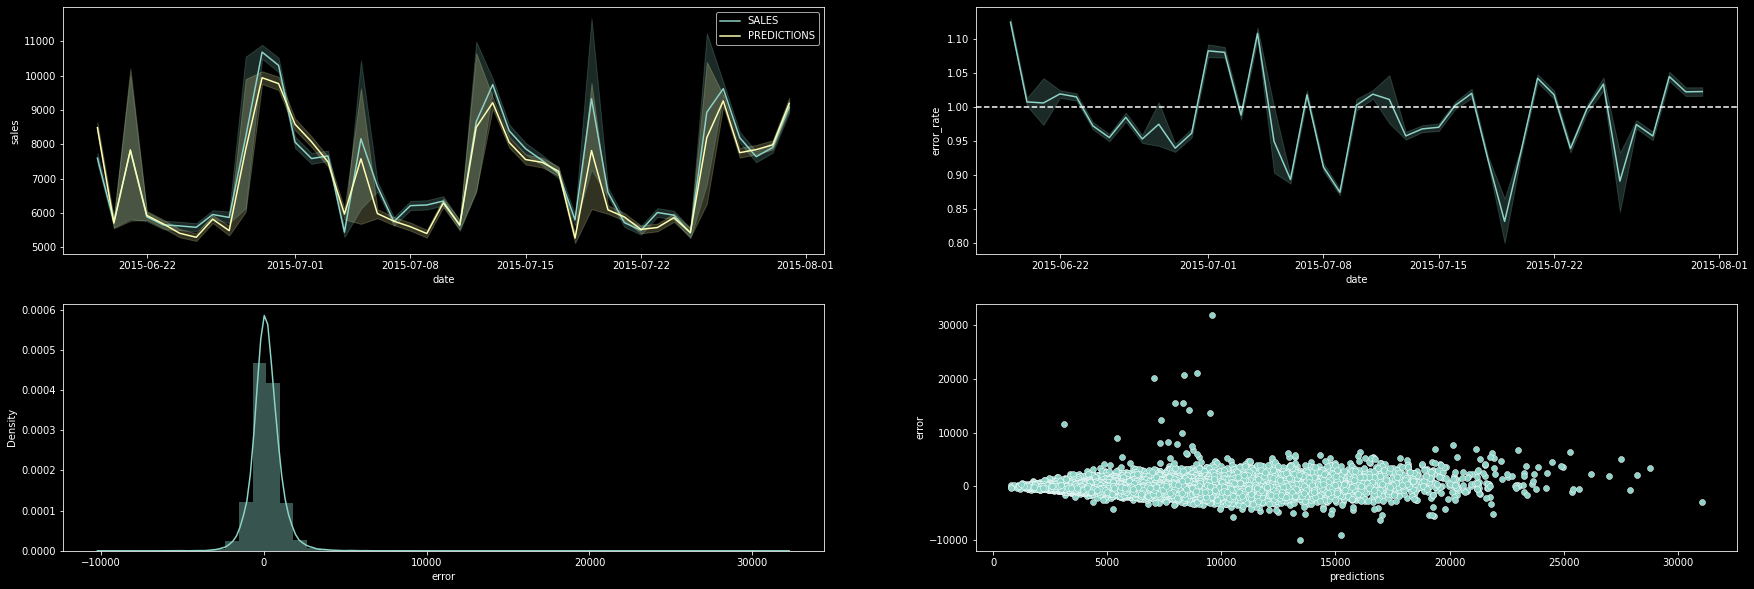

In [211]:
plt.subplot(2,2,1)
sns.lineplot( x='date', y='sales', data=df9, label='SALES')
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2,2,2)
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--' )

plt.subplot(2,2,3)
sns.distplot( df9['error'] )

plt.subplot(2,2,4)
sns.scatterplot( df9['predictions'], df9['error'] )


# 10. Deploy Model to Production

## 10.1 Rossman Class (Rossman.py)

In [564]:
import os
import pickle
import inflection
import pandas as pd
import numpy as np


class Rossmann( object ):
    
    def __init__( self ):
        
        self.home_path = r'G:\My Drive\courses\comunidads-ds\dsproducao\parameter'
        self.competition_distance_scaler = pickle.load( open( os.path.join( self.home_path, 'competition_distance_scaler.pkl'), 'rb') )
        self.competition_time_month_scaler = pickle.load( open( os.path.join( self.home_path, 'competition_time_month_scaler.pkl'), 'rb') )
        self.year_scaler = pickle.load( open( os.path.join( self.home_path, 'year_scaler.pkl'), 'rb') )
        self.promo_time_week_scaler = pickle.load( open( os.path.join( self.home_path, 'promo_time_week_scaler.pkl'), 'rb') )
        self.store_type_scaler = pickle.load( open( os.path.join( self.home_path, 'store_type_scaler.pkl'), 'rb') )
        
    
    def data_cleaning( self, df1):
        
        # rename columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
                    'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                    'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                    'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore(x)
        col_news = list( map( snakecase, cols_old ) )

        # rename
        df1.columns = col_news
        
        # change data types
        df1['date'] = pd.to_datetime( df1['date'] )

        # fillout NA
        
        # promo_interval   
        # nulos: loja não possui uma promoção periódica
        # criação de uma nova coluna que diz se naquela data estava começando uma nova promoção periódica na loja 
        month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}
        df1['promo_interval'].fillna(0, inplace=True)     
        df1['month_map'] = df1['date'].dt.month.map( month_map )
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval']==0 else 
                                                                                1 if x['month_map'] in x['promo_interval'].split(',') else 
                                                                                0, axis=1)

        # promo2_since_year  
        # nulos: loja não possui uma promoção periódica
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if pd.isna( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1)         
                
        # promo2_since_week    
        # nulos: loja não possui uma promoção periódica
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if pd.isna( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1)
                
        # competition_open_since_year
        # nulos: a loja não possui um competidor mais próxima ou a loja possui um competidor próximo, mas não se sabe quando essa loja abriu
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if pd.isna( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1)

        # competition_open_since_month
        # nulos: a loja não possui um competidor mais próxima ou a loja possui um competidor próximo, mas não se sabe quando essa loja abriu
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if pd.isna( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1)

        # competition_distance  
        # nulos: não existe nenhum competidor ou o competidor mais próximo está muito distante. 
        # Por esse motivo vamos substituir os nulos por uma distância muito alta
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if pd.isna(x) else x )


        # change data types
        df1.dtypes
        cols = ['competition_open_since_month', 'competition_open_since_year', 'promo2_since_week', 'promo2_since_year']

        for col in cols:
            df1[col] = df1[col].astype('int64')
            
            
        return df1
    
    
    def feature_engineering( self, df2):
        
        # feature engineering
        
        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype('int64')

        # year week
        df2['year_week'] = df2['year'].astype('str') + '-' + df2['week_of_year'].astype('str')

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )
        
        
        # filtragem das linhas
        df2 = df2[ ( df2['open'] != 0) ]
        
        # seleção das colunas
        cols_drop = [ 'open', 'promo_interval', 'month_map' ]
        df2 = df2.drop( cols_drop, axis=1 )
        
        
        return df2


    def data_preparation( self, df5):

        # rescaling

        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.transform( df5[['competition_distance']].values )
        
        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.transform( df5[['competition_time_month']].values )

        # year
        df5['year'] = self.year_scaler.transform( df5[['year']].values )

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.transform( df5[['promo_time_week']].values )


        # transformation
        ## encoding
        
        ### One Hot Encoding
        # state_holiday
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

        ### Label Encoding
        # store_type
        df5['store_type'] = self.store_type_scaler.transform( df5['store_type'] )

        ### Ordinal Encoding
        # assortment
        assortiment_dict = {'basic': 1,'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortiment_dict )

        ### Cyclical Nature Transformation
        # day
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2 * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2 * np.pi/30 ) ) )

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2 * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2 * np.pi/12 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2 * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2 * np.pi/52 ) ) )

        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2 * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2 * np.pi/7 ) ) )
        
        
        # features selected
        cols_selected = [
            'store',
            'promo',
            'store_type',
            'assortment',
            'competition_distance',
            'competition_open_since_month',
            'competition_open_since_year',
            'promo2',
            'promo2_since_week',
            'promo2_since_year',
            'competition_time_month',
            'promo_time_week',
            'day_sin',
            'day_cos',
            'month_sin',
            'month_cos',
            'week_of_year_sin',
            'week_of_year_cos',
            'day_of_week_sin',
            'day_of_week_cos'
        ]   

        
        return df5[ cols_selected ]
    
    
    def get_prediction( self, model, original_data, test_data ):
        
        # prediction
        pred = model.predict( test_data )

        # join pred into the original data
        original_data['prediction'] = np.expm1(pred)        
        
        return original_data.to_json( orient='records', date_format='iso' )


## 10.2 API Handler (Handler.py)

In [ ]:
import os
import pandas as pd
import pickle
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
home_path = r'G:\My Drive\courses\comunidads-ds\dsproducao\model'
model = pickle.load( open( os.path.join( home_path, 'model_rossmann.pkl'), 'rb') )


# initialize API
app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['POST'] )

def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: # if there is data        
        
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )        
        
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )  \
                
        # instanciate Rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
    
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3)
        
        return df_response
        
    else:
        return Response( '{}', status=200, mimetype='application/json' )


if __name__ == '__main__':
    app.run( '0.0.0.0' )


## 10.3 API Tester

In [361]:
# loading test dataset
path = r'G:\My Drive\courses\comunidads-ds\dsproducao\data'

df10 = pd.read_csv( os.path.join(path, 'test.csv') )
df_store_raw = pd.read_csv( '../data/store.csv', low_memory=False)

In [362]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# choose store for prediction
df_test = df_test[df_test['Store'].isin( [12, 20, 23, 22] )]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [363]:
#  convert dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [364]:
# API Call

#url = 'http://127.0.0.1:5000/rossmann/predict' #url local
url = 'https://lz-rossmann-model.herokuapp.com/rossmann/predict' #url heroku 
header = {'Content-type': 'application/json' } 
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [365]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [366]:
d1.head()

,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,prediction
0,12,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,a,extended,1070.0,...,2015,9,17,38,2015-38,2015-09-01T00:00:00.000Z,0,2010-03-22T00:00:00.000Z,286,6927.265137
1,20,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,d,basic,2340.0,...,2015,9,17,38,2015-38,2009-05-01T00:00:00.000Z,77,2014-09-29T00:00:00.000Z,50,6611.396484
2,22,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,a,basic,1040.0,...,2015,9,17,38,2015-38,2015-09-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,173,4898.148438
3,23,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,d,basic,4060.0,...,2015,9,17,38,2015-38,2005-08-01T00:00:00.000Z,123,2015-09-14T00:00:00.000Z,0,6084.063965
4,12,3,2015-09-16T00:00:00.000Z,1.0,1,regular_day,0,a,extended,1070.0,...,2015,9,16,38,2015-38,2015-09-01T00:00:00.000Z,0,2010-03-22T00:00:00.000Z,286,7145.835449


In [355]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format( 
            d2.loc[i, 'store'], 
            d2.loc[i, 'prediction'] ) )

Store Number 12 will sell R$248,348.40 in the next 6 weeks
Store Number 20 will sell R$263,280.78 in the next 6 weeks
Store Number 22 will sell R$178,600.05 in the next 6 weeks
Store Number 23 will sell R$239,351.51 in the next 6 weeks
